## Mural cells (MCs) 2021/08/04 - Part B: Generating the main figures
Author: Jorge Ruiz-Orera

Remaining plots that are not in the notebook:

-Figure 1B: Generated by the DGE edgeR notebook

-Figure S1D: Generated by the DGE edgeR notebook

-Figure S1F: RNAscope image

In [1]:
import os
import anndata
import logging
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import leidenalg
import csv
from pandas import Timestamp
import re
import matplotlib.pyplot as plt
from scipy.stats import rankdata 
import scipy
import harmonypy as hm
import random
from scipy.stats.stats import pearsonr   
import scipy.sparse
from SCCAF import *
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 120, color_map = 'RdBu_r')

Running Scanpy 1.5.1, on 2021-08-05 12:44.


In [2]:
%load_ext rpy2.ipython

## Functions

In [4]:
def plot_celltype_abundance(adata_obs, Region, variable='leiden_annotated', 
                            normalised_by=None, 
                            Genes_column='Gene',
                            Genes_to_plot=['PKP2', 'LMNA', 'PLN', 'RBM20', 'TTN', 'DES', 'control', 'mutation negative'], 
                            celltypes_to_plot=['CM', 'FB', 'MP', 'EC'], plottype="boxplot", 
                            show_points=True, return_table=False, save_png=None, ylimit=None):
    # Example how to use this function=
    # plot_celltype_abundance(adata_obs, 'AP', 'global_annotated'), where adata_obs=adata.obs
    
    count=0 # This is needed in case one genotype is not found
    
    # Subsetting for region
    if Region == "LV":
        tmp=adata_obs[adata_obs['Region'].isin(['FW', 'AP'])]
    
    elif Region == "LVS":
        tmp=adata_obs[adata_obs['Region'].isin(['FW', 'AP', 'S'])]
    
    elif Region == "all":
        tmp=adata_obs
    else:
        tmp=adata_obs[adata_obs['Region'].isin([Region])]
    
    # Calculates percentage per gene
    for gene_nr in range(len(Genes_to_plot)):
    #gene_nr=0
        Gene=Genes_to_plot[gene_nr]
        tmp_=tmp[tmp[Genes_column].isin([Gene])]
        if celltypes_to_plot is not None: ###Added line
            tmp_=tmp_[tmp_[variable].isin(celltypes_to_plot)]  ###Added line
        ax= pd.crosstab(tmp_['Patient'], 
                        tmp_[variable]).apply(lambda r: r/r.sum()*100, axis=1).copy()
        if ax.shape[0]==0:
            continue
        if celltypes_to_plot is not None:
            ax=ax[celltypes_to_plot]#, 'FB', 'EC', 'MP', 'PC']]
            celltypes_to_plot=celltypes_to_plot[0:]
        if normalised_by is not None:
            normalize=ax[normalised_by]
            ax=ax.apply(lambda r: r/normalize, axis=0)
            y_axis_title="% celltype / "+ normalised_by
        else:
            y_axis_title="% celltype"
            
        index_ax = ax.index.to_frame(index=False) 
        ax = ax.reset_index(drop=True) 
        ax = pd.merge(index_ax, ax, left_index=True, right_index=True) 
        ax_melt=pd.melt(ax, id_vars='Patient')
        ax_melt[Genes_column]=Gene + " (n=" + str(ax.shape[0]) + ")"
        if ax.shape[0] != 0: 
            if count==0:
                final_df = ax_melt
                count=+1
            else:
                final_df=pd.concat([final_df, ax_melt], axis=0)
                
    # If you want to have a table only
    if return_table == True:
        return final_df
    
    # If you want to have a plot only
    else:
        %matplotlib inline
        plt.figure(figsize=[14,10], dpi=200, facecolor='w', edgecolor='k')
        if plottype == "boxplot":
            sns.set_style(style='white')
            flierprops = dict(markerfacecolor='0.75', markersize=3,
                          linestyle='none')
            if show_points is True:
                ax=sns.swarmplot(x="variable", y="value", hue=Genes_column, data=final_df, color=".25", dodge=True, size=3)
            ax=sns.boxplot(x="variable", y='value', hue=Genes_column, data=final_df, flierprops=flierprops, showfliers = False)
            handles, labels = ax.get_legend_handles_labels()
            plt.legend(handles[0:len(set(final_df[Genes_column]))], labels[0:len(set(final_df[Genes_column]))], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.set_ylabel(y_axis_title,fontsize=40)
            ax.set_xlabel("Cell type",fontsize=40)
            ax.tick_params(labelsize=30)
            if ylimit is not None:
                ax.set(ylim=(0, ylimit))
        elif plottype == "violinplot":           
            if show_points == True:
                ax = sns.violinplot(x="variable", y="value", hue=Genes_column, data=final_df, inner="points")
            else:
                ax = sns.violinplot(x="variable", y="value", hue=Genes_column, data=final_df) 
            handles, labels = ax.get_legend_handles_labels()
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
            plt.legend(handles[0:len(set(final_df[Genes_column]))], labels[0:len(set(final_df[Genes_column]))], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
            ax.set_ylabel(y_axis_title,fontsize=40)
            ax.set_xlabel("Cell type",fontsize=40)
            ax.tick_params(labelsize=30)
            ax
    
    # If you want to save the figure
    if save_png != None:
        plt.savefig(save_png, transparent=True)

In [6]:
def filter_by_expression(adata_obj, DE_column, key='rank_genes_groups'):
#adata_obj=fbs_new_harmony.copy()
#key='rank_genes_groups'
#DE_column='leiden'
    def to_tensor(dataframe, columns = [], dtypes = {}, index = False):
        to_records_kwargs = {'index': index}
        if not columns:  # Default to all `dataframe.columns`
            columns = dataframe.columns
        if dtypes:       # Pull in modifications only for dtypes listed in `columns`
            to_records_kwargs['column_dtypes'] = {}
            for column in dtypes.keys():
                if column in columns:
                    to_records_kwargs['column_dtypes'].update({column: dtypes.get(column)})
        return dataframe[columns].to_records(**to_records_kwargs)
    gene_names = pd.DataFrame(adata_obj.uns[key]['names'])
    fraction_in_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    fraction_notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    in_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    allin_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    allnotin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    # Create a Adata raw with raw in .X -> We might remove this step - redundant!
    dummy=anndata.AnnData(X=adata_obj.raw.X,
                   var=adata_obj.raw.var,
                   obs=adata_obj.obs)
    # We split the adata by Cell-type. Genes are ordered according to ranks from DEgene analysis
    dummy_split=[dummy[dummy.obs[DE_column].isin([i]),
                  gene_names[i]] for i in gene_names.columns]
    dummy_split_adatasize=[i.shape[0] for i in dummy_split] # How many cells we have in-cluster
    dummy_outcluster=[dummy[~dummy.obs[DE_column].isin([i]),
                       gene_names[i]] for i in gene_names.columns]
    dummy_split_adatasize_outcluster=[i.shape[0] for i in dummy_outcluster] # How many cells we have in out-cluster
    for adata, sizeof_adata, adata_outcluster, sizeof_adata_outcluster in zip(dummy_split, dummy_split_adatasize, 
                                                     dummy_outcluster, dummy_split_adatasize_outcluster):
        cluster_number=[(adata.obs[DE_column].unique()).tolist()][0]
        #incluster_rows, incluster_cols=adata.X.nonzero()
        #https://stackoverflow.com/questions/3797158/counting-non-zero-elements-within-each-row-and-within-each-column-of-a-2d-numpy
        #incluster_counts = [len(np.where(incluster_cols==i)[0]) for i in range(0,adata.shape[1])]
        incluster_counts=np.diff(adata.X.tocsc().indptr)
        percent_expression_incluster=np.array(incluster_counts)/sizeof_adata 
        fraction_in_cluster_matrix[cluster_number[0]]=percent_expression_incluster
        #outcluster_rows, outcluster_cols=adata_outcluster.X.nonzero()
        #outcluster_counts = [len(np.where(outcluster_cols==i)[0]) for i in range(0,adata_outcluster.shape[1])]
        outcluster_counts=np.diff(adata_outcluster.X.tocsc().indptr)
        percent_expression_outcluster=np.array(outcluster_counts)/sizeof_adata_outcluster 
        fraction_notin_cluster_matrix[cluster_number[0]]=percent_expression_outcluster
        # Expression_all in cluster
        allin_cluster_expr_matrix[cluster_number[0]]=np.squeeze(np.asarray(adata.X.mean(axis=0)))
        allnotin_cluster_matrix[cluster_number[0]]=np.squeeze(np.asarray(adata_outcluster.X.mean(axis=0)))
    # Generate the last table results
    result = adata_obj.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result['pi'] = to_tensor(fraction_in_cluster_matrix)
    result['po'] = to_tensor(fraction_notin_cluster_matrix)
    result['ei'] = to_tensor(allin_cluster_expr_matrix)
    result['eo'] = to_tensor(allnotin_cluster_matrix)
    results =pd.DataFrame(
        {group + '_' + key[:2]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges', 'pi', 'po', "ei", "eo"]})
    return results

In [9]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [10]:
def correlation_analysis(scanpy_object, column_tosplitby, sum_or_mean):
    d = {}
    for cluster_number in np.unique(scanpy_object.obs[column_tosplitby].values):
        #cluster_number=np.unique(heart.obs['louvain_annotated'].values)[1]
        scanpy_object_subset = scanpy_object[scanpy_object.obs[column_tosplitby].isin([cluster_number])]

        if sum_or_mean=="mean":
            d[cluster_number] = np.squeeze(np.asarray(scanpy_object_subset.raw.X.mean(axis=0))) #np.log(+1)
        elif sum_or_mean=="sum":
            d[cluster_number] = np.squeeze(np.asarray(scanpy_object_subset.raw.X.sum(axis=0))) #np.log(+1)
        del scanpy_object_subset
        
    return d

In [11]:
def stacked_barplot(adata, xaxis, stack, xaxis_label, legend_label,shift_top=0.2, xaxis_rotation=0):
    tmp=pd.crosstab(adata.obs[xaxis],
                adata.obs[stack]).sum(axis=1)    
    
    ax= pd.crosstab(adata.obs[xaxis],
                    adata.obs[stack]).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)
    #display(ax)
    #plt.legend(title="Subject") # loc='upper center', bbox_to_anchor=(0.1, 1.0),
    plt.rc('font', size=5)
    plt.legend(loc='best', bbox_to_anchor=(1, 0.5), title=legend_label)
    plt.xlabel(xaxis_label)
    plt.ylabel('Percent Distribution')  
    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, rec.get_y() + height/2, "{:.0f}%".format(height),
               ha = 'center', va='center') #    
    for xaxistick in range(ax.shape[0]):
        ax_1.text(xaxistick-shift_top,110,tmp[xaxistick],va='center')   
    
    plt.xticks(rotation=90)    
    ax_1.grid(False)
    plt.show()

In [12]:
def makevector_topmarkers(results, top_n, tag, ldFC_cutoff=0.5, pvals_adj_cutoff=10**-30, expression_in=1): 
    #Modified function to include ei scores, needs the result from  filter_by_expression instead of an anndata object
    #clusters = list(set(map(lambda x: x.split("_")[0],expression.columns)))
    clusters = ["PC1","PC2","PC3","SMC1.1","SMC1.2","SMC2"]
    top_genes=[]
    for cluster in clusters:
        topgenes_cluster=results[cluster + "_na"][(results[cluster + "_lo"]>=ldFC_cutoff) & 
                                                            (results[cluster + "_pv"]<(pvals_adj_cutoff)) &
                                                           (results[cluster + "_ei"]>=expression_in)]
        fc = results[cluster + "_lo"][(results[cluster + "_lo"]>=ldFC_cutoff) & 
                                                            (results[cluster + "_pv"]<(pvals_adj_cutoff)) &
                                                           (results[cluster + "_ei"]>=expression_in)]
        top_genes.extend(topgenes_cluster[0:top_n])
    return(top_genes)

In [17]:
def average_expression(adata, GOI, cell_states, Region=['FW', 'AP', 'S']):

    FB_all_nobackground_harmony_LV=adata[adata.obs.cell_states.isin(cell_states) &
                                                               adata.obs.Region.isin(Region)
                                                              ].copy()
    
    y=correlation_analysis(FB_all_nobackground_harmony_LV, 'Patient', 'mean')
    y=pd.DataFrame.from_dict(y)
    y.index=FB_all_nobackground_harmony_LV.raw.var.index
    
    x=FB_all_nobackground_harmony_LV.copy()
    PKP2_list=x[x.obs['Clinical.dominant.mutation'].isin(['PKP2'])].obs.Patient.unique()
    LMNA_list=x[x.obs['Clinical.dominant.mutation'].isin(['LMNA'])].obs.Patient.unique()
    RBM20_list=x[x.obs['Clinical.dominant.mutation'].isin(['RBM20'])].obs.Patient.unique()
    TTN_list=x[x.obs['Clinical.dominant.mutation'].isin(['TTN'])].obs.Patient.unique()
    control_list=x[x.obs['Clinical.dominant.mutation'].isin(['control'])].obs.Patient.unique()
    MN_list=x[x.obs['Clinical.dominant.mutation'].isin(['mutation negative'])].obs.Patient.unique()
    
    genes_to_investigate=GOI#
    
    #genes_to_investigate=['ADAM12', 'CNBD1', 'COL12A1', 'COL4A5', 'COL8A1', 'FAM20A', 'FAP', 'HMCN1', 'NPPB', 'PDGFC', 'PLA2R1', 'POSTN', 'SERPINE2', 'SLIT3', 'SMOC2', 'SSC5D', 'ST6GAL1', 'TLL2'
    #                     ]
    
    
    df1=pd.melt(y.loc[genes_to_investigate,LMNA_list].reset_index(), id_vars='index')
    df1['Diagnosis']="LMNA"
    df1.columns=['Gene', 'Patient', 'Exp', 'Diagnosis']
    
    df2=pd.melt(y.loc[genes_to_investigate,PKP2_list].reset_index(), id_vars='index')
    df2['Diagnosis']="PKP2"
    df2.columns=['Gene', 'Patient', 'Exp', 'Diagnosis']
    
    df3=pd.melt(y.loc[genes_to_investigate,RBM20_list].reset_index(), id_vars='index')
    df3['Diagnosis']="RBM20"
    df3.columns=['Gene', 'Patient', 'Exp', 'Diagnosis']
    
    df4=pd.melt(y.loc[genes_to_investigate,TTN_list].reset_index(), id_vars='index')
    df4['Diagnosis']="TTN"
    df4.columns=['Gene', 'Patient', 'Exp', 'Diagnosis']
    
    df5=pd.melt(y.loc[genes_to_investigate,control_list].reset_index(), id_vars='index')
    df5['Diagnosis']="control"
    df5.columns=['Gene', 'Patient', 'Exp', 'Diagnosis']
    
    df6=pd.melt(y.loc[genes_to_investigate,MN_list].reset_index(), id_vars='index')
    df6['Diagnosis']="mutation negative"
    df6.columns=['Gene', 'Patient', 'Exp', 'Diagnosis']
    
    df=df5.append([df1,df4, df3, df2, df6])
    
    return df

### Read the anndata file

In [18]:
random_state=10
#results_file = '/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/MC/Results/MC_20210302all_harmony.h5ad'
results_file = 'MC_20210302all_harmony.h5ad'

BO_30 = sc.read_h5ad(results_file)
BO_30.obs['leiden_main'] = "other"
BO_30.obs['leiden_main'][BO_30.obs['cell_states'].isin(["PC1","PC2","PC3"])] = "PC"
BO_30.obs['leiden_main'][BO_30.obs['cell_states'].isin(["SMC1.1","SMC1.2","SMC2"])] = "SMC"
mural = BO_30[BO_30.obs.leiden_main.isin(['SMC','PC'])]
mural = mural[mural.obs['Clinical.dominant.mutation'].isin(['control','mutation negative','PVneg','LMNA','TTN','RBM20','PKP2'])].copy()
mural.obs['cell_states_long-Gene'] = mural.obs[['cell_states_long','Clinical.dominant.mutation']].agg('/'.join, axis=1)
mural.obs["Region2"] = "LV"
mural.obs.Region2[mural.obs.Region == "RV"] = "RV"
mural.obs['region-Gene'] = mural.obs[['Region2','Clinical.dominant.mutation']].agg('/'.join, axis=1)

<ipython-input-18-4a08ca58ccaa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BO_30.obs['leiden_main'][BO_30.obs['cell_states'].isin(["PC1","PC2","PC3"])] = "PC"
<ipython-input-18-4a08ca58ccaa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BO_30.obs['leiden_main'][BO_30.obs['cell_states'].isin(["SMC1.1","SMC1.2","SMC2"])] = "SMC"
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*arg

In [19]:
mural

AnnData object with n_obs × n_vars = 147253 × 6476
    obs: 'Patient', 'Sample', 'Gender', 'Gene', 'Diagnosis', 'Clinical.dominant.mutation', 'Age', 'Mutation.Type', 'Genomic.location', 'Region', 'Origin', 'n_genes', 'percent_mito', 'percent_ribo', 'X10X_version', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_z', 'predicted_doublets_z', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_20200602', 'cell_type_20200602', 'cell_type_20200921', 'cell_type_global_HCA', 'cell_states_HCA', 'cell_type_fine_20200921', 'cell_states_20200921', 'cell_states_long_20200921', 'cell_states_20210218', 'validated_20210218', 'leiden_01', 'leiden_02', 'leiden_03', 'leiden_04', 'cell_type', 'batch', 'leiden', 'leiden_annotated', 'cell_states', 'cell_states_long', 'leiden_main', 'Region2', 'cell_states_long-Gene', 'region-Gene'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'G

... storing 'leiden_main' as categorical
... storing 'Region2' as categorical
... storing 'cell_states_long-Gene' as categorical
... storing 'region-Gene' as categorical


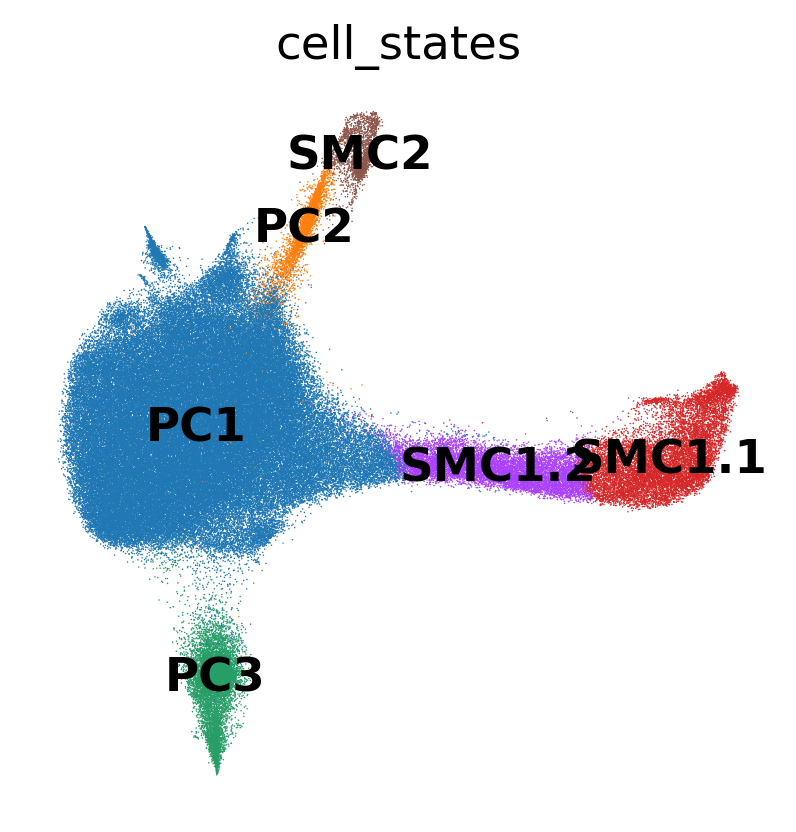

In [20]:
sc.pl.umap(mural, 
           color=['cell_states'], legend_loc='on data',
           projection='2d', components=['1,2'], frameon=False, save = "Fig1A_UMAP")

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


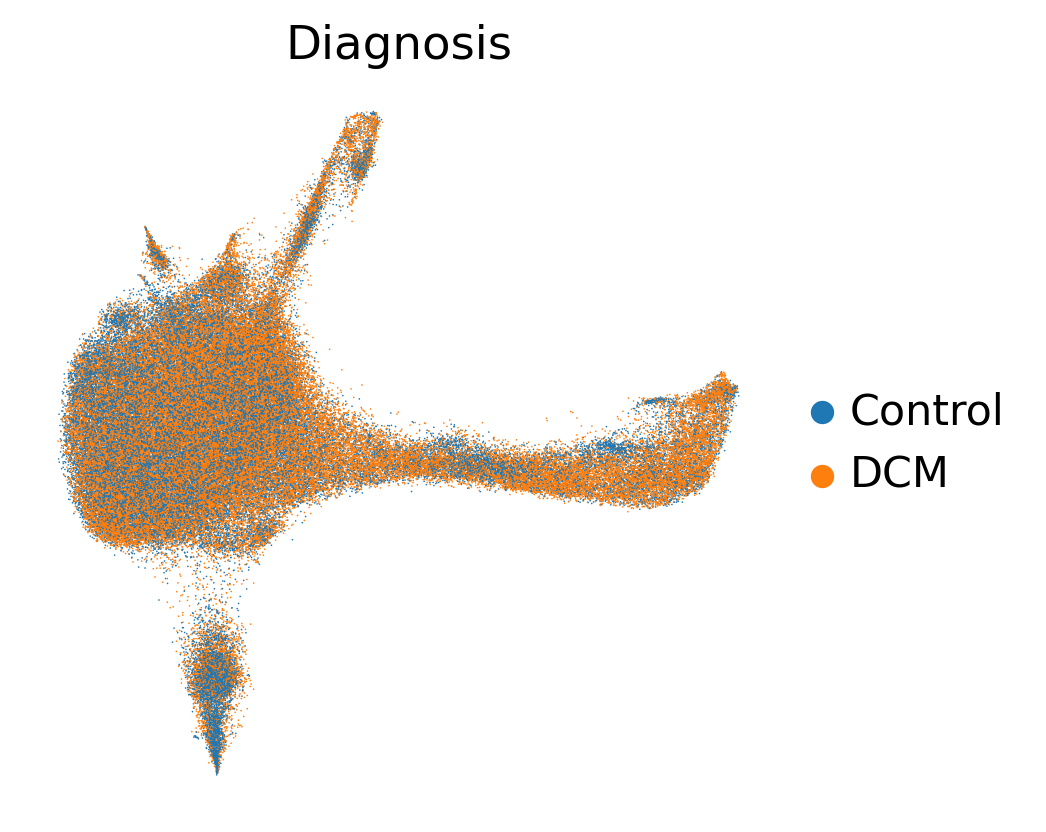

In [21]:
sc.pl.umap(mural[mural.obs.Diagnosis != "ARVC"], color=['Diagnosis'],
           projection='2d', components=['1,2'], frameon=False, save = "FigS1A_UMAP_A")

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


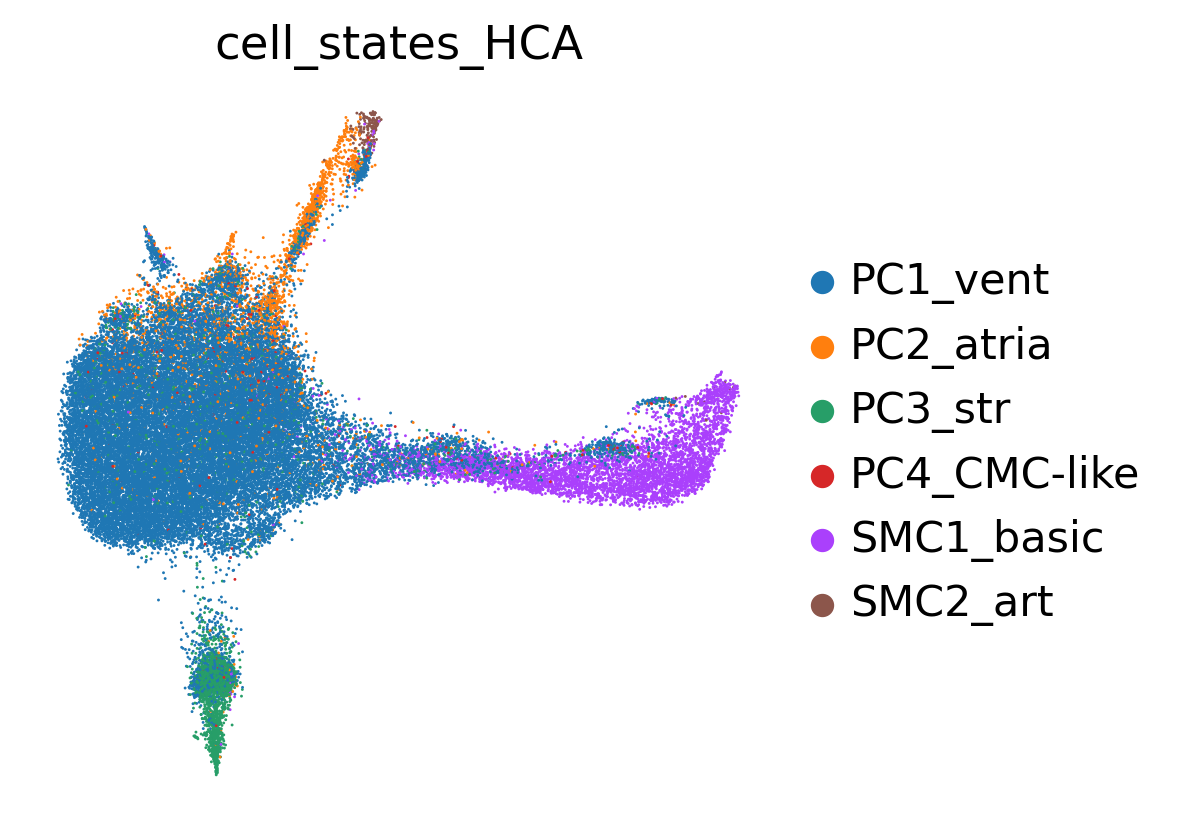

In [22]:
sc.pl.umap(mural[mural.obs.cell_states_HCA.isin(list(filter(lambda x:re.search(r'^PC|^SMC|Meso', x), mural.obs.cell_states_HCA)))],color=['cell_states_HCA'], color_map = 'RdPu', frameon=False, save = "FigS1A_UMAP_B")

## Marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:06:55)


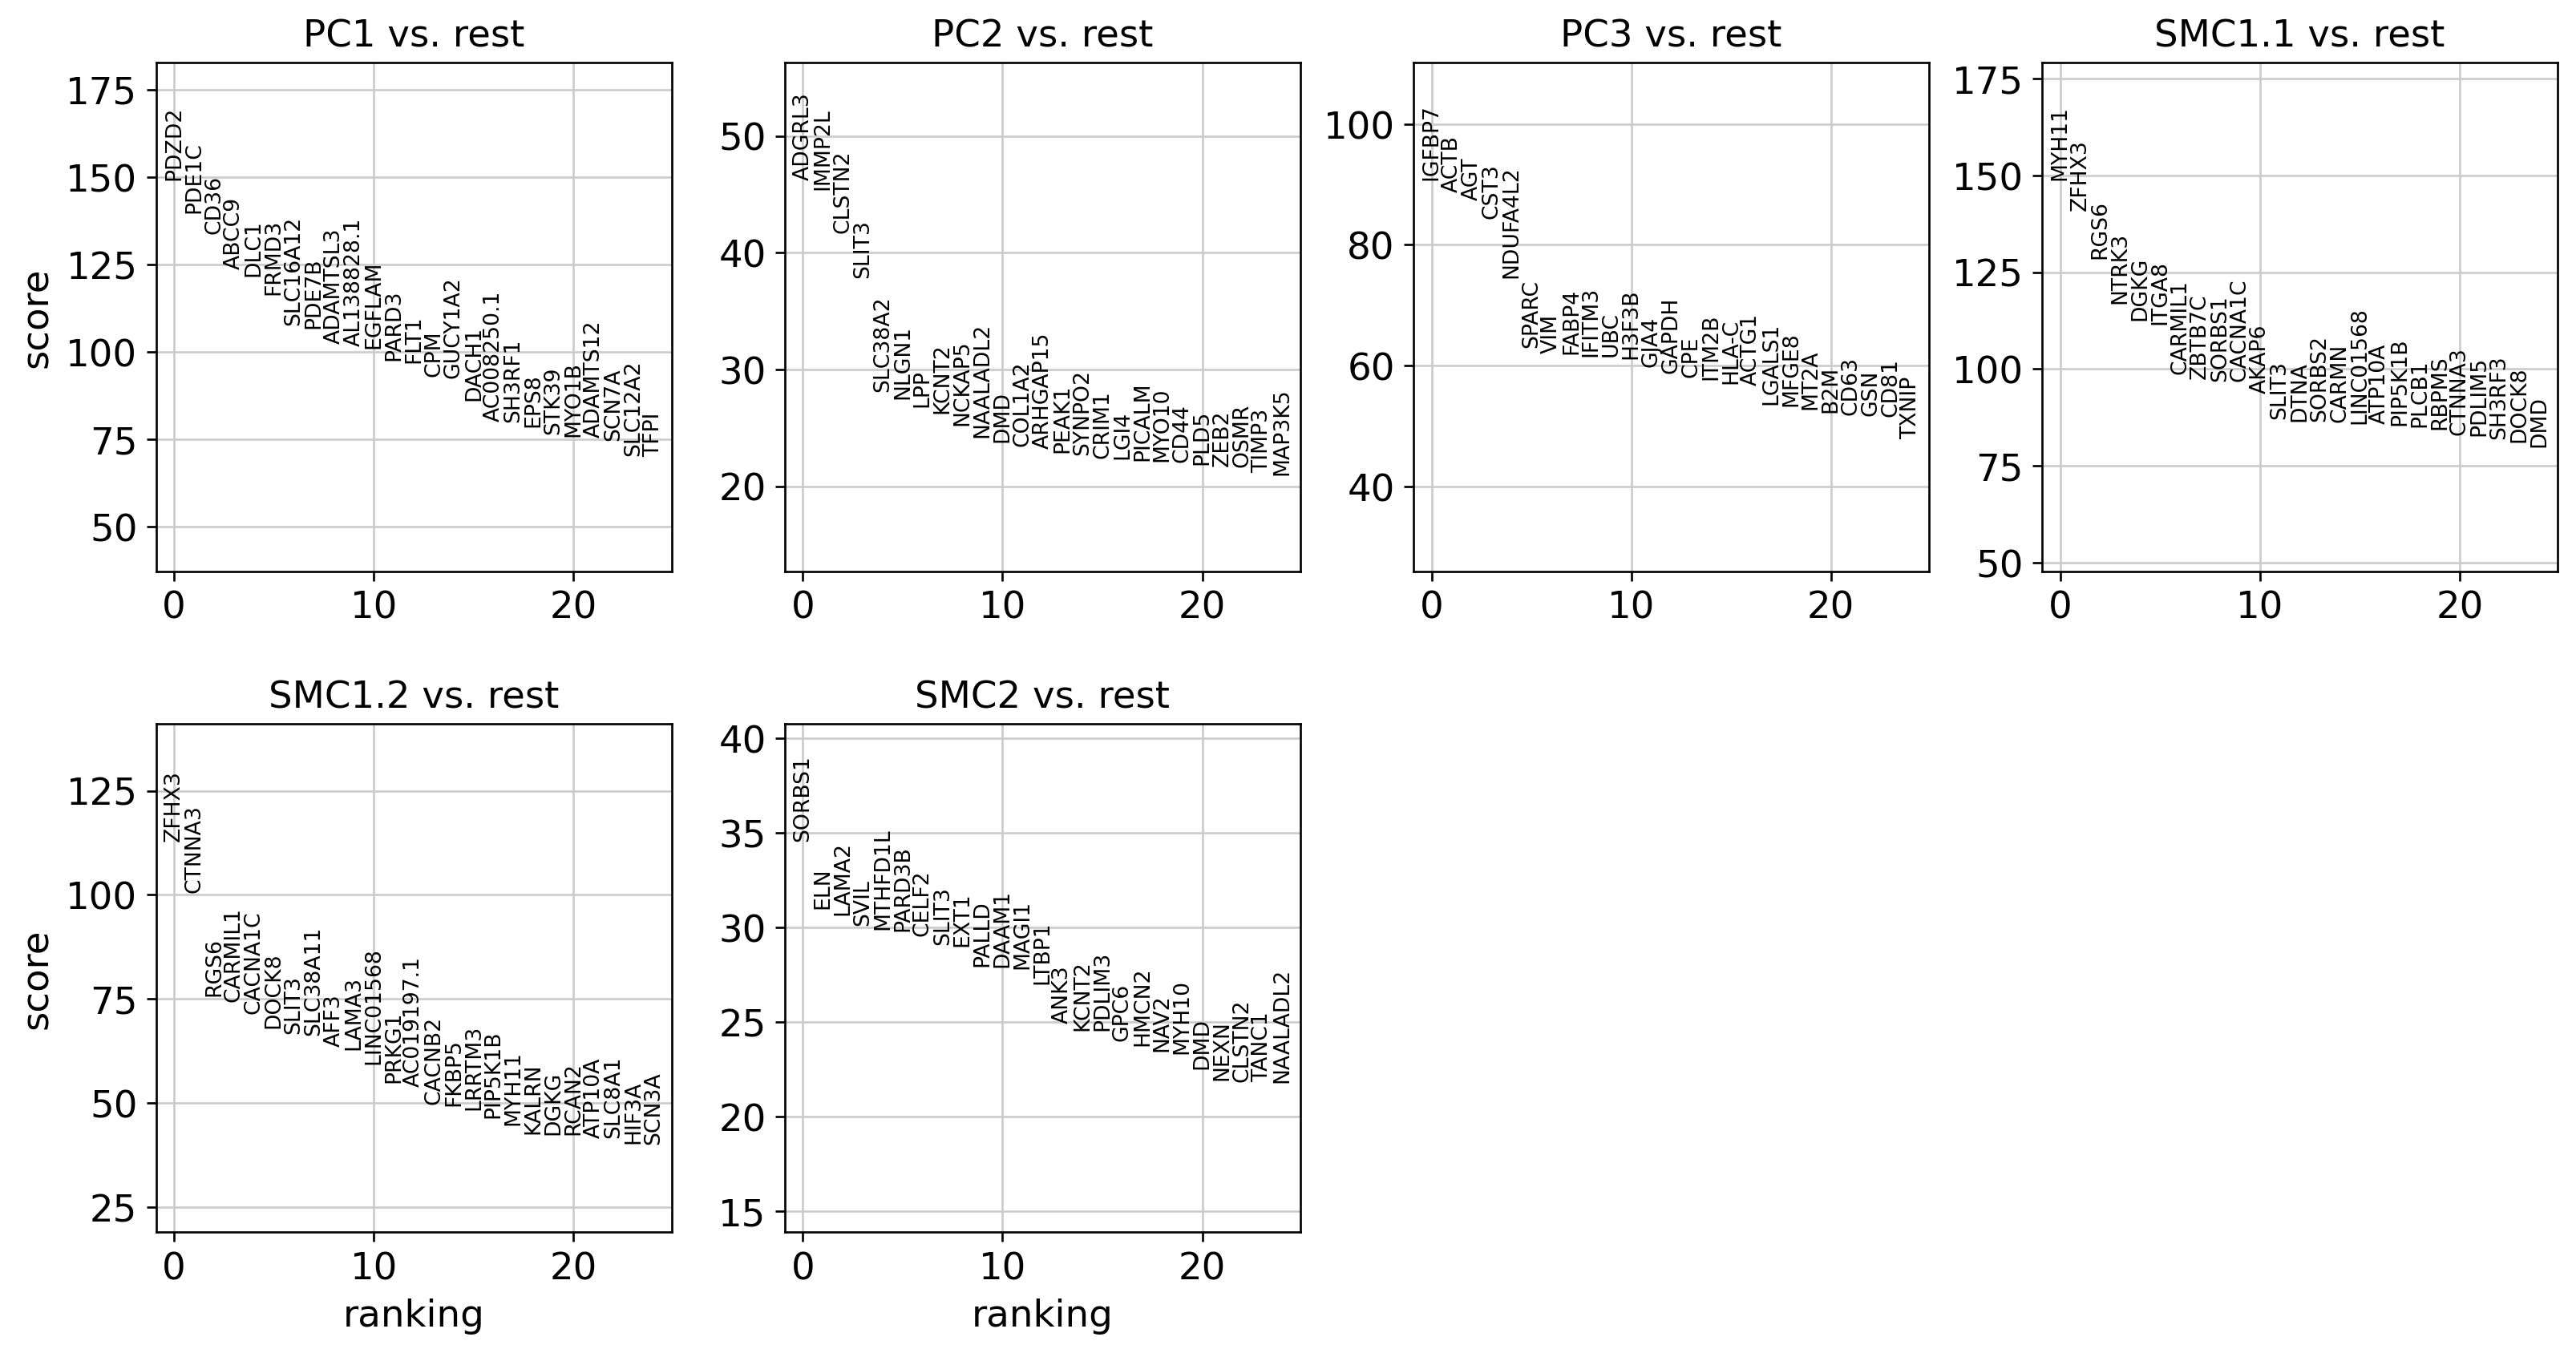

In [23]:
#Calculate top DE genes per cell state
sc.tl.rank_genes_groups(mural, 'cell_states', method='wilcoxon')
sc.pl.rank_genes_groups(mural, n_genes=25, sharey=False)

In [24]:
expression_cellstates=filter_by_expression(mural, 'cell_states', key='rank_genes_groups')
expression_cellstates.head(n=5)

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


PC1_na  PC1_pv    PC1_lo    PC1_pi    PC1_po    PC1_ei    PC1_eo   PC2_na  \
0  PDZD2     0.0  2.254337  0.914143  0.572654  3.115655  1.707711   ADGRL3   
1  PDE1C     0.0  2.303908  0.816404  0.411268  2.387105  1.099018   IMMP2L   
2   CD36     0.0  2.127582  0.896816  0.544261  2.944234  1.632796   CLSTN2   
3  ABCC9     0.0  2.219641  0.740515  0.340008  2.071219  0.911803    SLIT3   
4   DLC1     0.0  0.944974  0.986270  0.944424  4.348407  3.705282  SLC38A2   

          PC2_pv    PC2_lo  ...  SMC1.2_po  SMC1.2_ei  SMC1.2_eo  SMC2_na  \
0   0.000000e+00  2.412982  ...   0.633911   3.559800   1.813176   SORBS1   
1   0.000000e+00  1.711698  ...   0.286877   2.338423   0.704846      ELN   
2   0.000000e+00  4.324258  ...   0.131781   1.634775   0.356472    LAMA2   
3   0.000000e+00  2.998138  ...   0.356182   2.152503   0.936527     SVIL   
4  4.135231e-171  1.394384  ...   0.869000   3.382248   2.686943  MTHFD1L   

         SMC2_pv   SMC2_lo   SMC2_pi   SMC2_po   SMC2_ei   SMC2_eo  
0  3.458796e-258  2.870417  0.527874  0.174239  1.524111  0.399493  
1  1.812574e-207  4.113879  0.396002  0.047016  1.126617  0.113716  
2  3.883489e-203  1.992221  0.658977  0.362200  2.099567  1.029743  
3  1.070451e-195  2.487826  0.480200  0.166524  1.228945  0.358375  
4  4.218320e-193  4.550384  0.367166  0.028150  0.938357  0.064285  

[5 rows x 42 columns]

In [27]:
lista = makevector_topmarkers(expression_cellstates, 
                                    5, "clusters_20210804", ldFC_cutoff=1, pvals_adj_cutoff=10**-10, expression_in=0.5)

lista = lista + ["ABCC9","KCNJ8","ACTA2","TAGLN","EXT1","MYH10","DAAM1","TNC"]

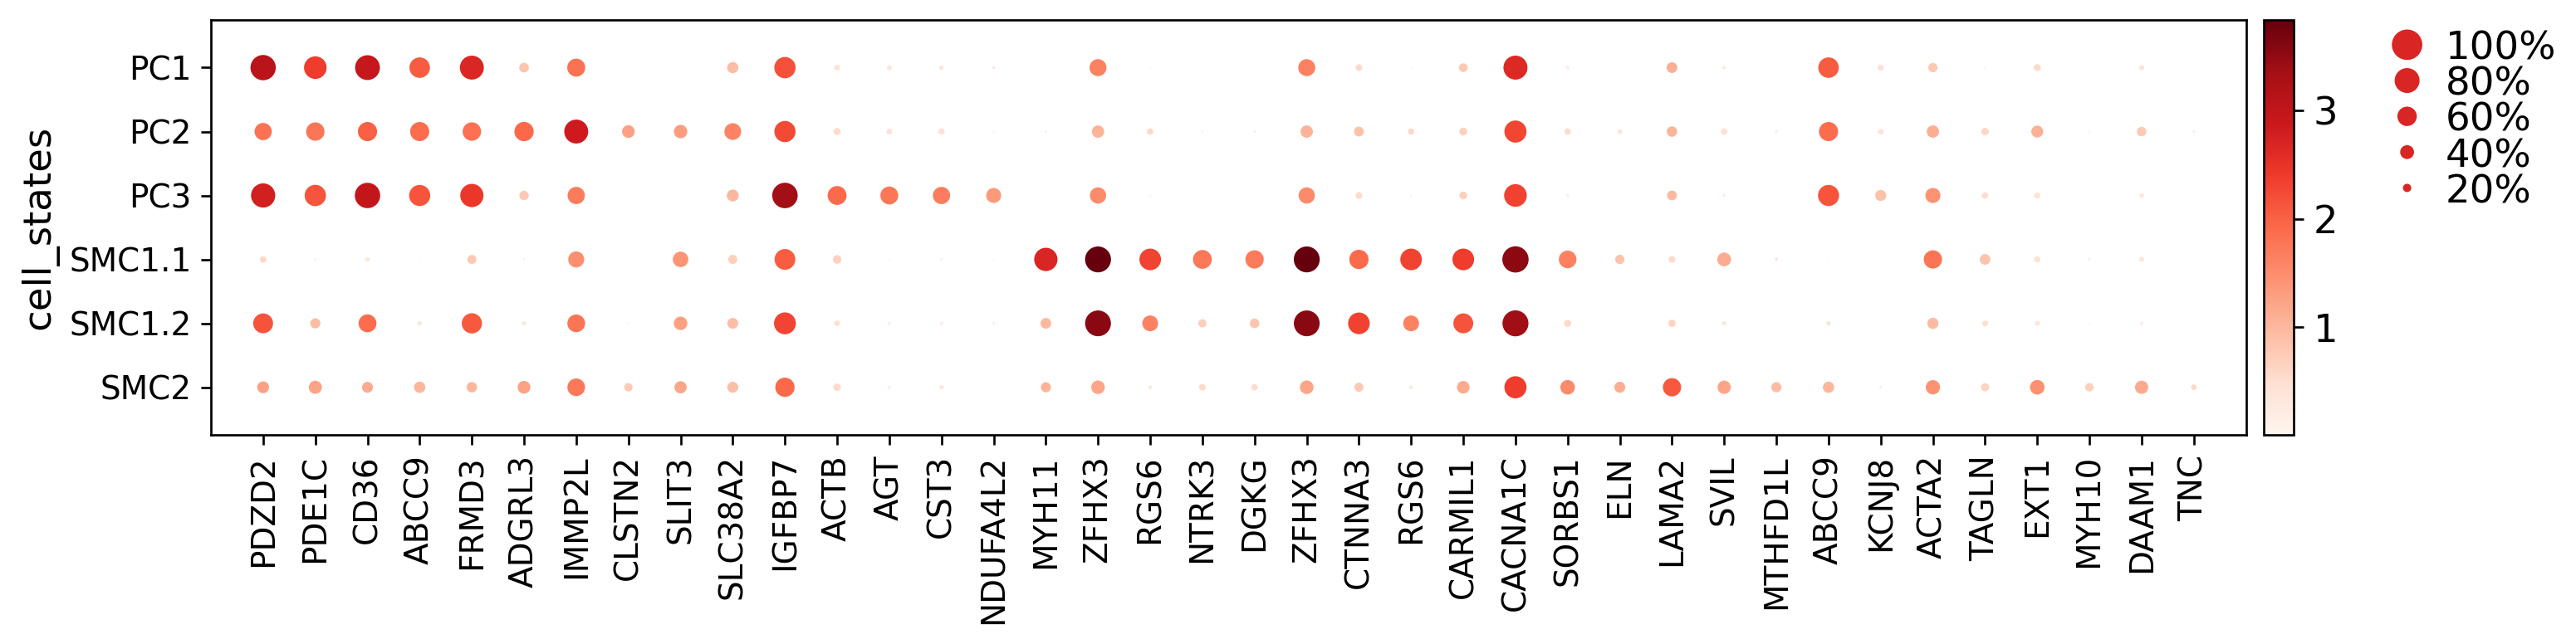

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[13.299999999999999, 0, 0.2, 0.5, 0.25])

In [28]:
sc.pl.dotplot(mural,
             lista,
              groupby='cell_states', use_raw=True)

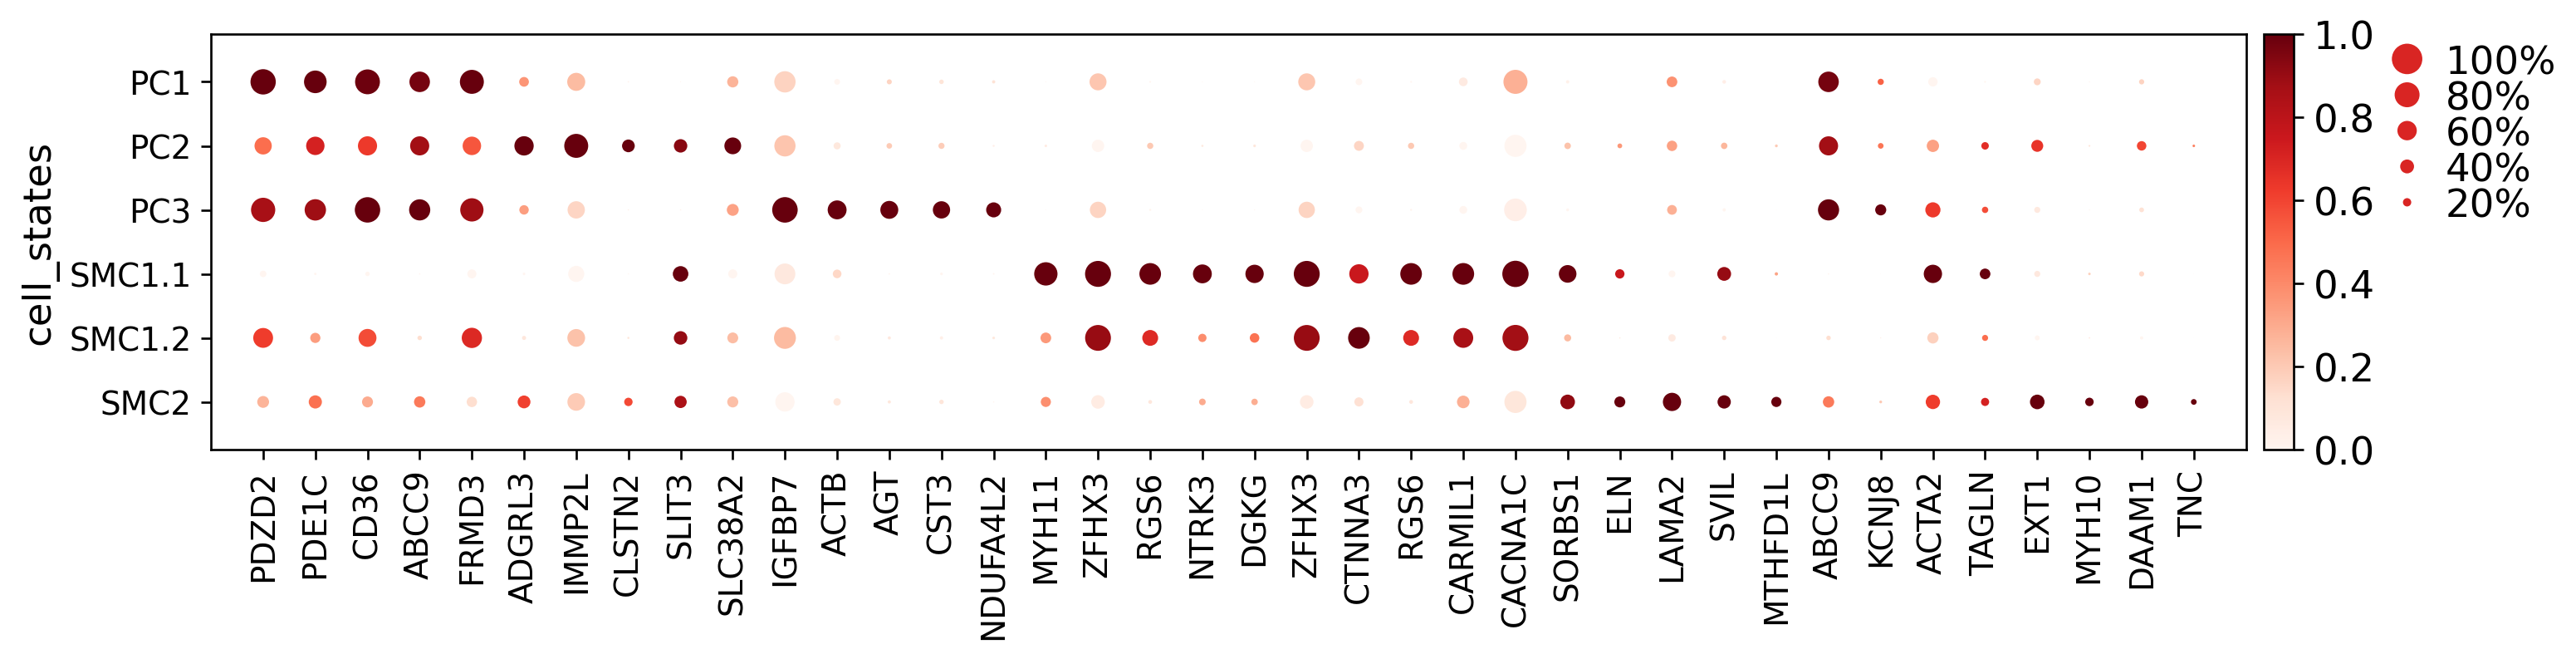

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[13.299999999999999, 0, 0.2, 0.5, 0.25])

In [29]:
sc.pl.dotplot(mural,
             lista,
              groupby='cell_states', use_raw=True, standard_scale='var', save = "FigS1B_markers")

In [30]:
mural.obs['Clinical.dominant.mutation'].cat.reorder_categories(['control','LMNA','TTN','RBM20','PKP2','mutation negative'], inplace=True)

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


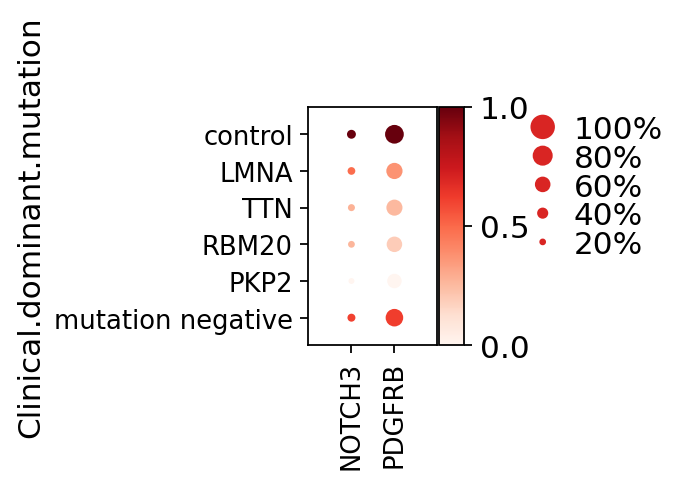

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[1.05, 0, 0.2, 0.5, 0.25])

In [31]:
sc.set_figure_params(scanpy=True, fontsize=14)
sc.pl.dotplot(mural[mural.obs.leiden_main == "PC"],['NOTCH3','PDGFRB'],groupby="Clinical.dominant.mutation", 
              dot_min = 0, dot_max = 1, use_raw=True,figsize=[2,2],
              standard_scale='var', save = "Fig1C_markersA_PCs")

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


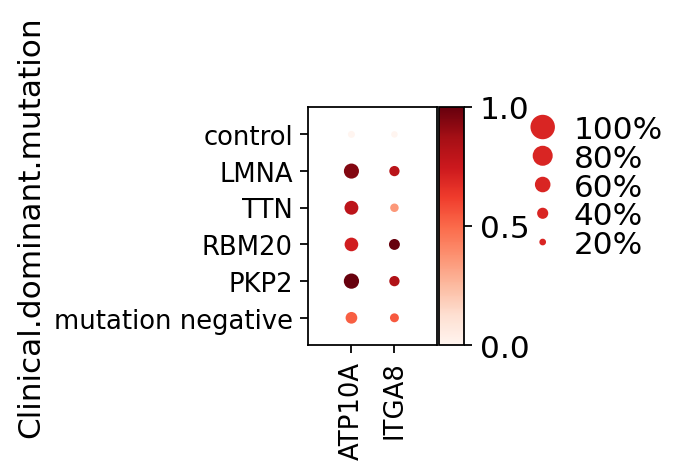

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[1.05, 0, 0.2, 0.5, 0.25])

In [32]:
sc.pl.dotplot(mural[mural.obs.cell_states.isin(["SMC1.1","SMC1.2"])],['ATP10A','ITGA8'],groupby="Clinical.dominant.mutation", 
              dot_min = 0, dot_max = 1, use_raw=True,figsize=[2,2],
              standard_scale='var', save = "Fig1C_markersB_SMC1")

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


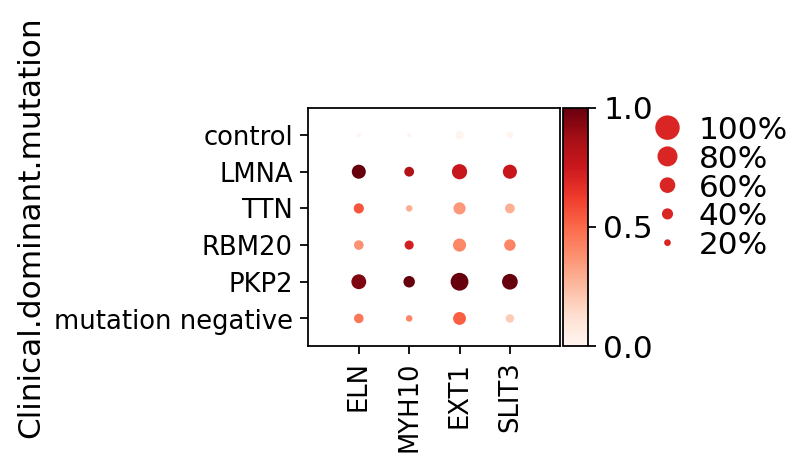

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.05, 0, 0.2, 0.5, 0.25])

In [33]:
sc.pl.dotplot(mural[mural.obs.cell_states.isin(["SMC2"])],['ELN','MYH10','EXT1','SLIT3'],groupby="Clinical.dominant.mutation", 
              dot_min = 0, dot_max = 1, use_raw=True,figsize=[3,2],
              standard_scale='var', save = "Fig1C_markersC_SMC2")

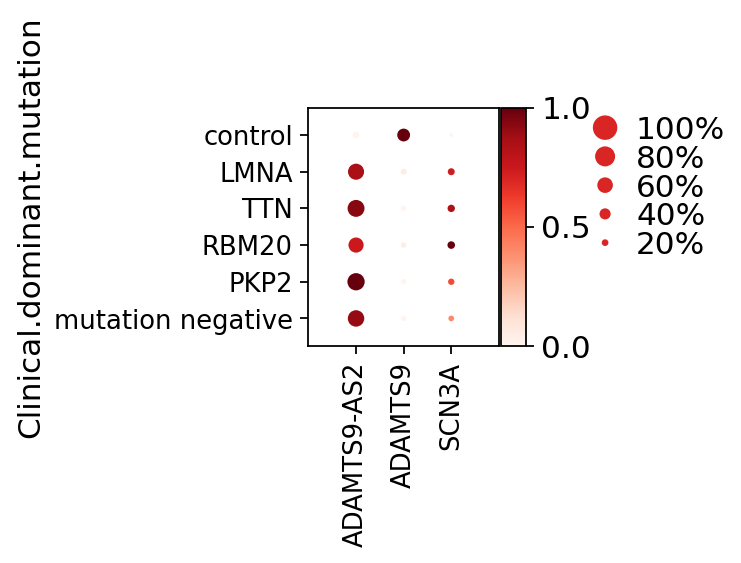

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[1.55, 0, 0.2, 0.5, 0.25])

In [34]:
sc.pl.dotplot(mural,['ADAMTS9-AS2','ADAMTS9','SCN3A'],groupby="Clinical.dominant.mutation", 
              dot_min = 0, dot_max = 1, use_raw=True,figsize=[2.5,2],
              standard_scale='var', save = "Fig1C_markersD_MCs")

In [35]:
#expression.to_csv(path_out + "MC_CELLSTATE_DEG_WILCOX.csv")

# STEP 3: Abundance per cell-state per Region

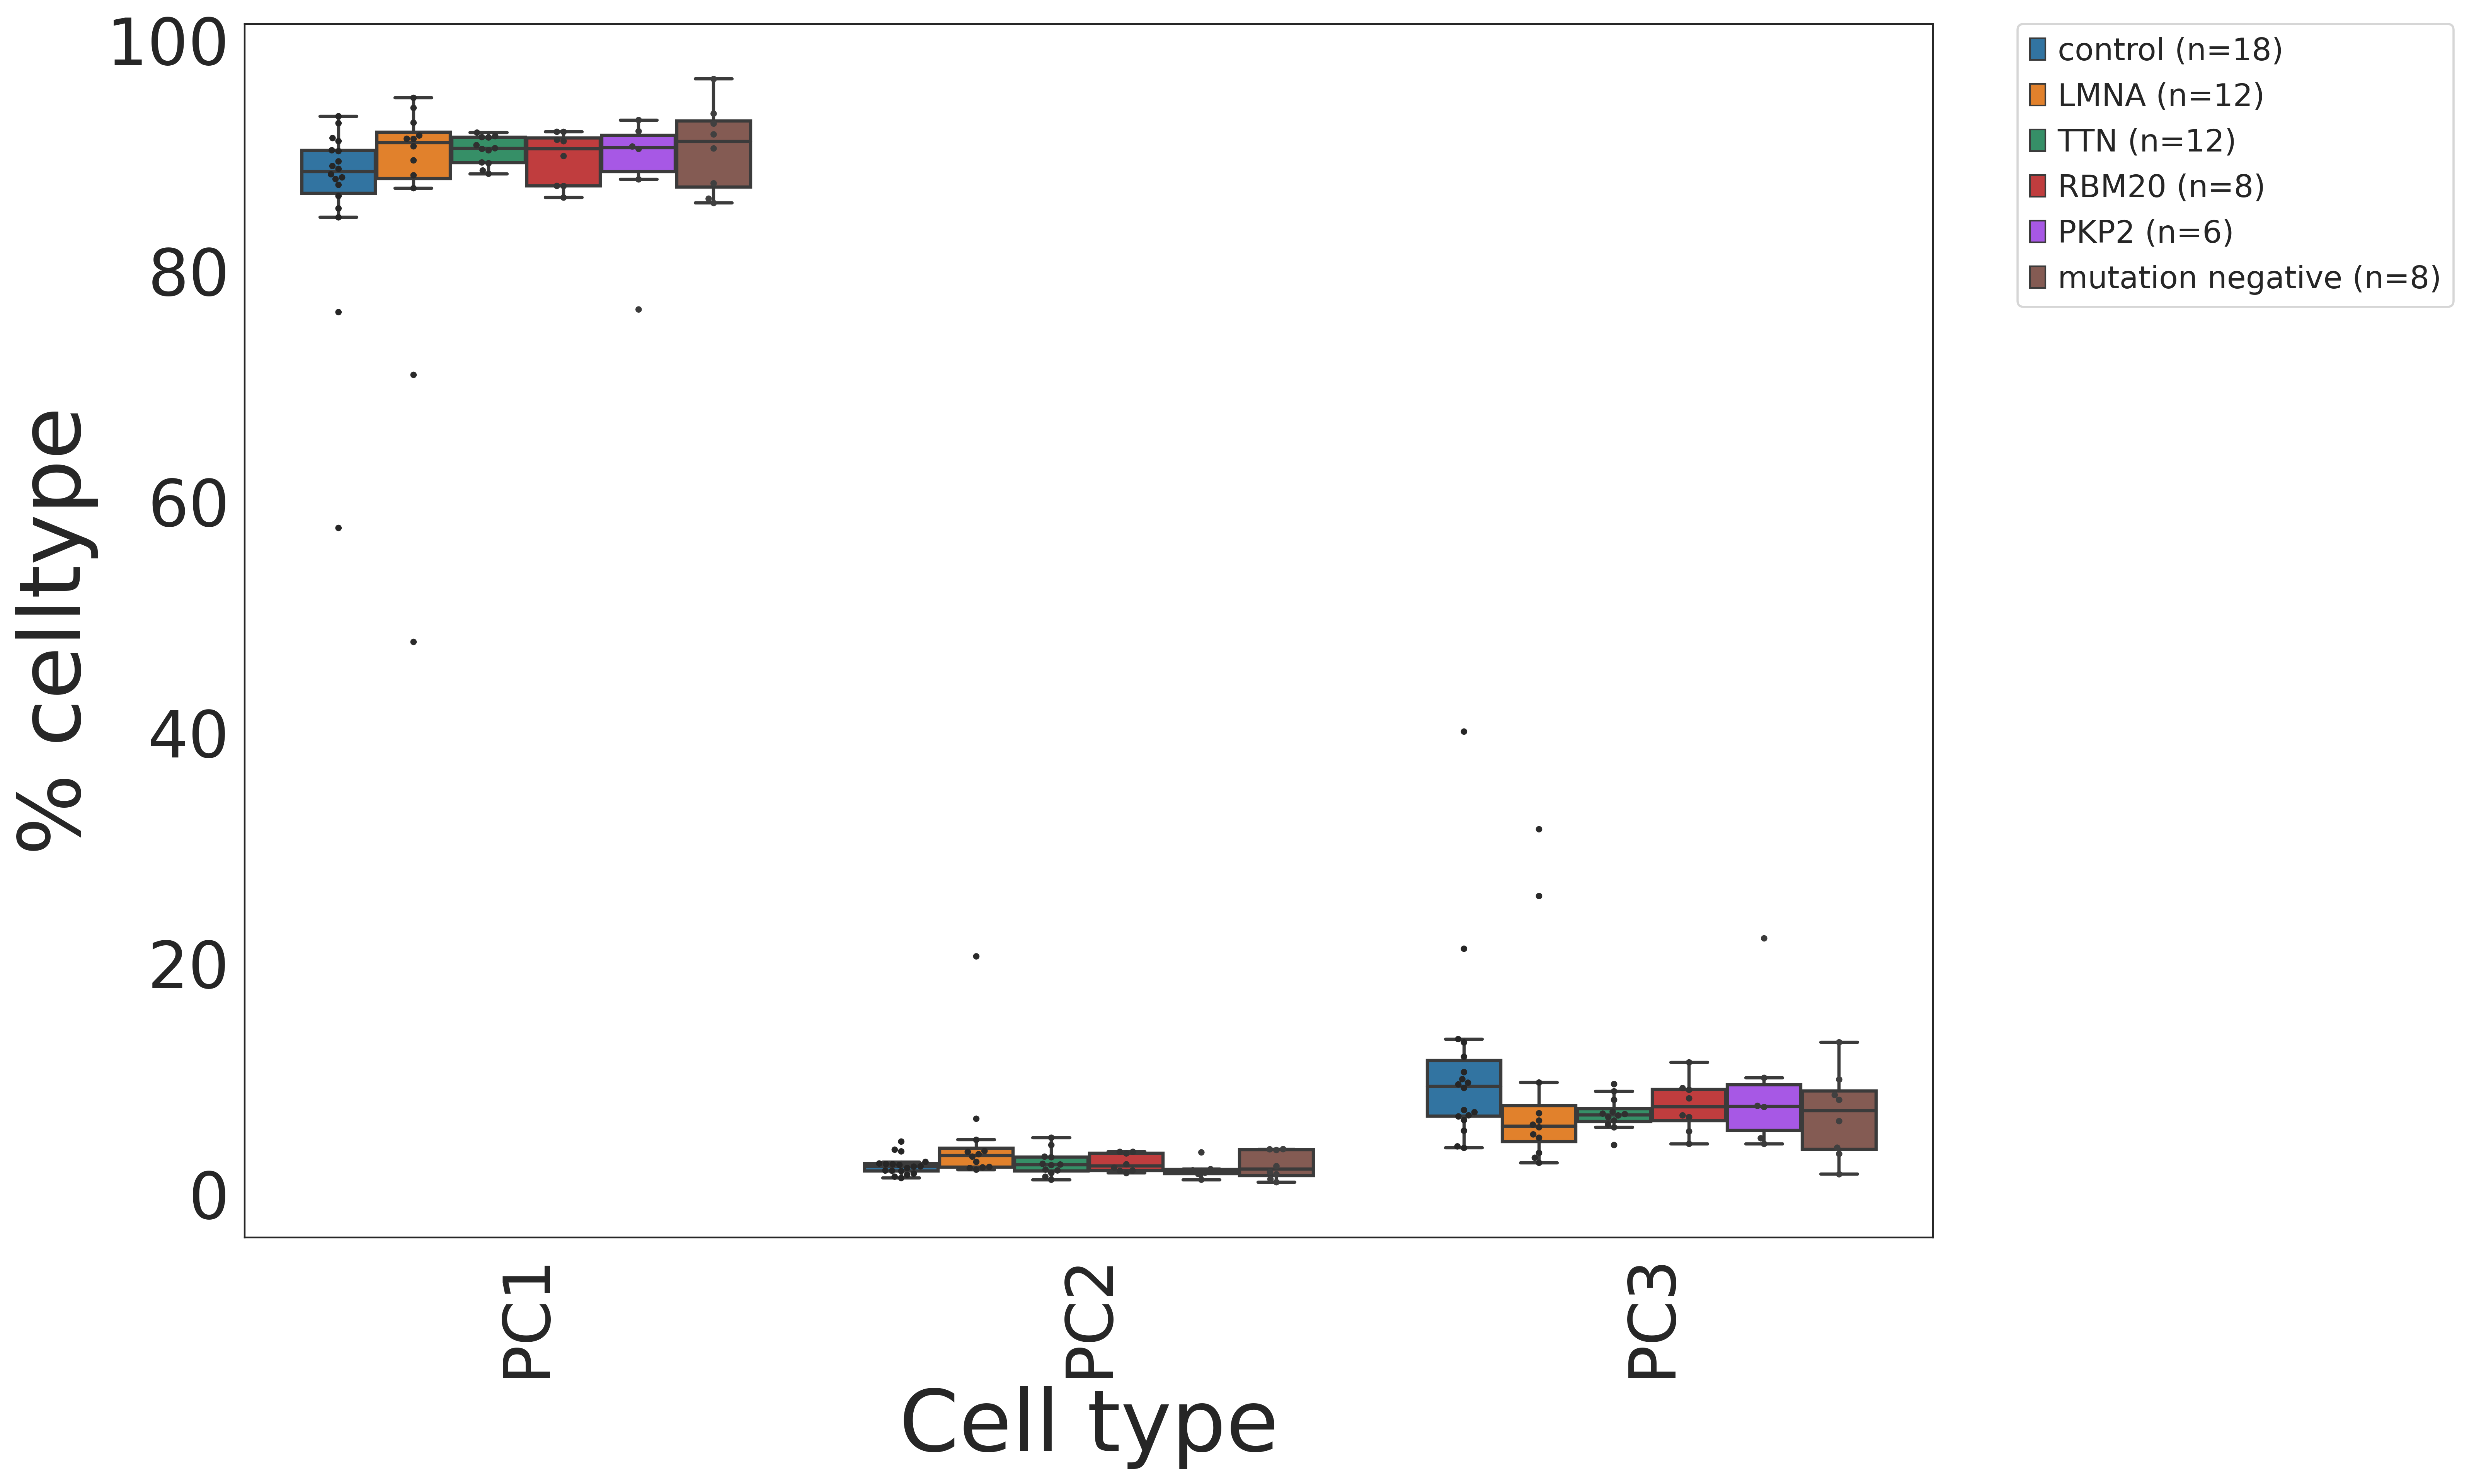

In [36]:
plot_celltype_abundance(mural.obs, 'LVS', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['PC1', 'PC2', 'PC3'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png='figures/FigS1C_LV_PC_ab.pdf', ylimit=None)

In [37]:
x=plot_celltype_abundance(mural.obs, 'LVS', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['PC1', 'PC2', 'PC3'], 
                            plottype="boxplot", 
                            return_table=True)
x.columns=['Patient', 'cell_state', 'abundance_percent', 'Mutation']
#x.to_csv("PC_CELLSTATE_ABUNDANCE_LV.csv")
x

Patient cell_state  abundance_percent                 Mutation
0   BS_H15        PC1          89.063266           control (n=18)
1   BS_H20        PC1          91.221683           control (n=18)
2   BS_H25        PC1          90.429918           control (n=18)
3   BS_H26        PC1          91.487030           control (n=18)
4   BS_H35        PC1          93.376131           control (n=18)
..     ...        ...                ...                      ...
19     H56        PC3           8.142494  mutation negative (n=8)
20     H57        PC3           3.465347  mutation negative (n=8)
21     H58        PC3           1.699029  mutation negative (n=8)
22     H59        PC3           4.000000  mutation negative (n=8)
23  IC_H04        PC3          13.131313  mutation negative (n=8)

[192 rows x 4 columns]

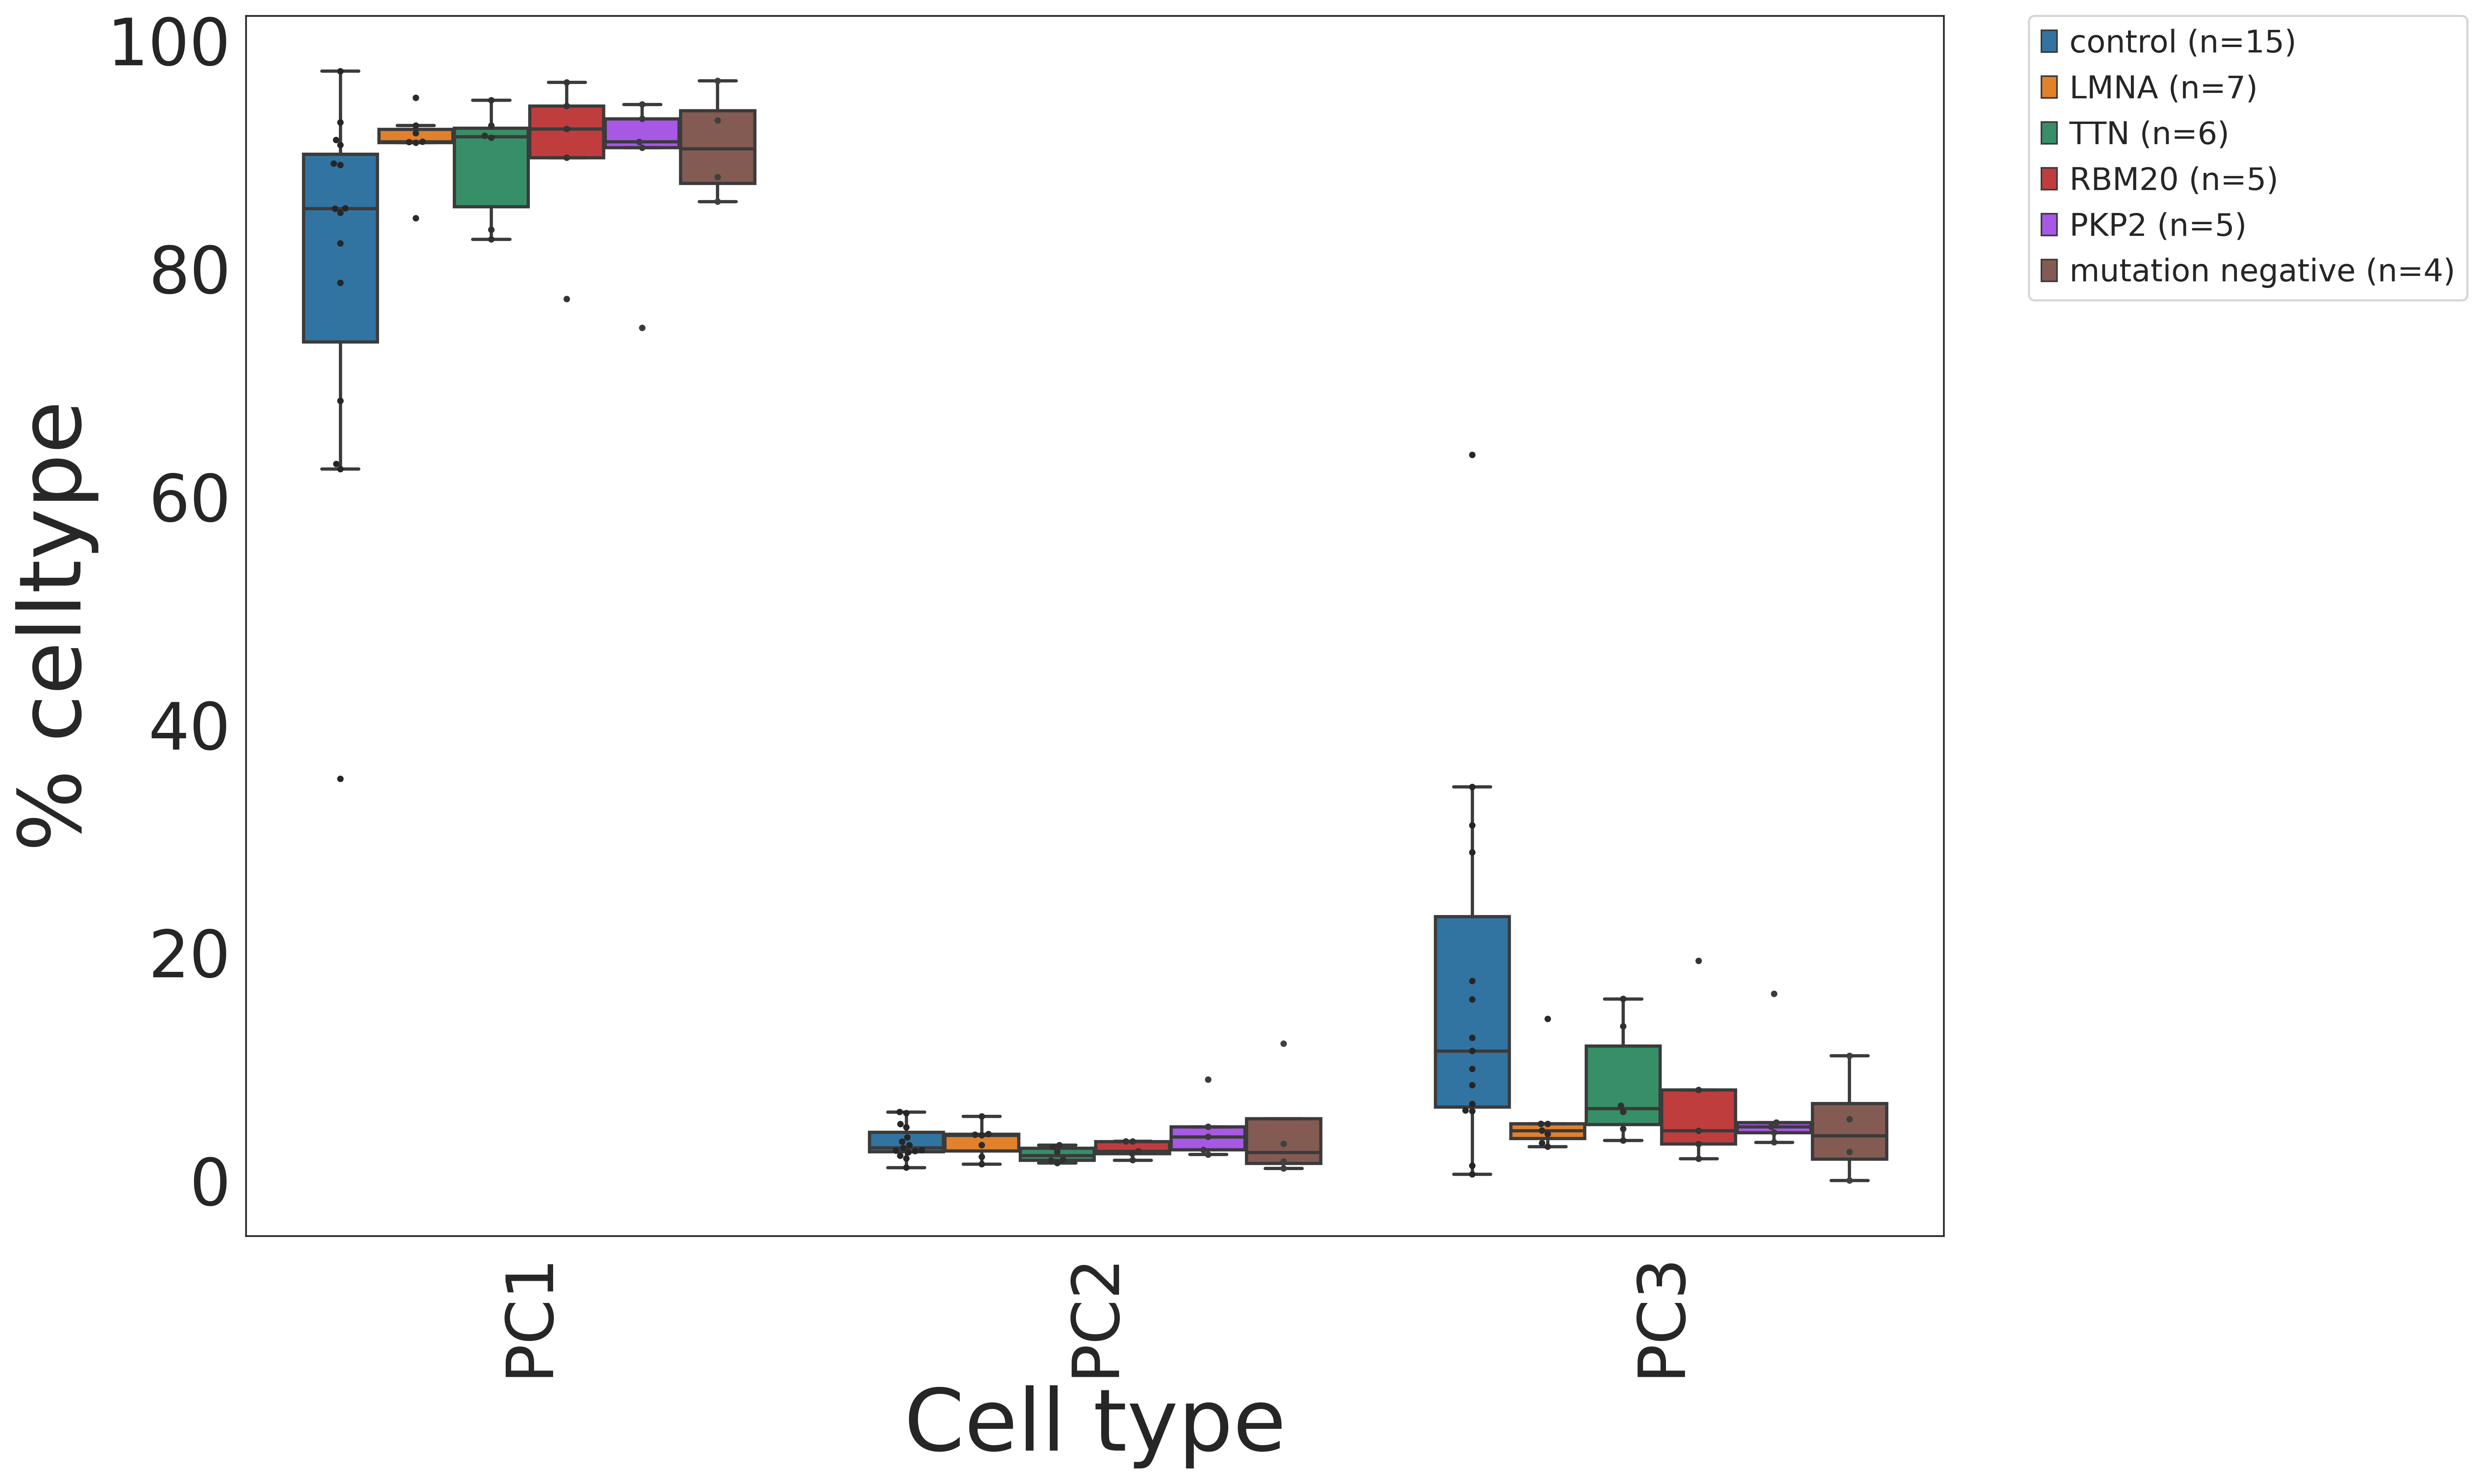

In [38]:
plot_celltype_abundance(mural.obs, 'RV', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['PC1', 'PC2', 'PC3'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png='figures/FigS1C_RV_PC_ab.pdf', ylimit=None)

In [39]:
x=plot_celltype_abundance(mural.obs, 'LVS', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['PC1', 'PC2', 'PC3'], 
                            plottype="boxplot", 
                            return_table=True)
x.columns=['Patient', 'cell_state', 'abundance_percent', 'Mutation']
#x.to_csv("PC_CELLSTATE_ABUNDANCE_RV.csv")
x

Patient cell_state  abundance_percent                 Mutation
0   BS_H15        PC1          89.063266           control (n=18)
1   BS_H20        PC1          91.221683           control (n=18)
2   BS_H25        PC1          90.429918           control (n=18)
3   BS_H26        PC1          91.487030           control (n=18)
4   BS_H35        PC1          93.376131           control (n=18)
..     ...        ...                ...                      ...
19     H56        PC3           8.142494  mutation negative (n=8)
20     H57        PC3           3.465347  mutation negative (n=8)
21     H58        PC3           1.699029  mutation negative (n=8)
22     H59        PC3           4.000000  mutation negative (n=8)
23  IC_H04        PC3          13.131313  mutation negative (n=8)

[192 rows x 4 columns]

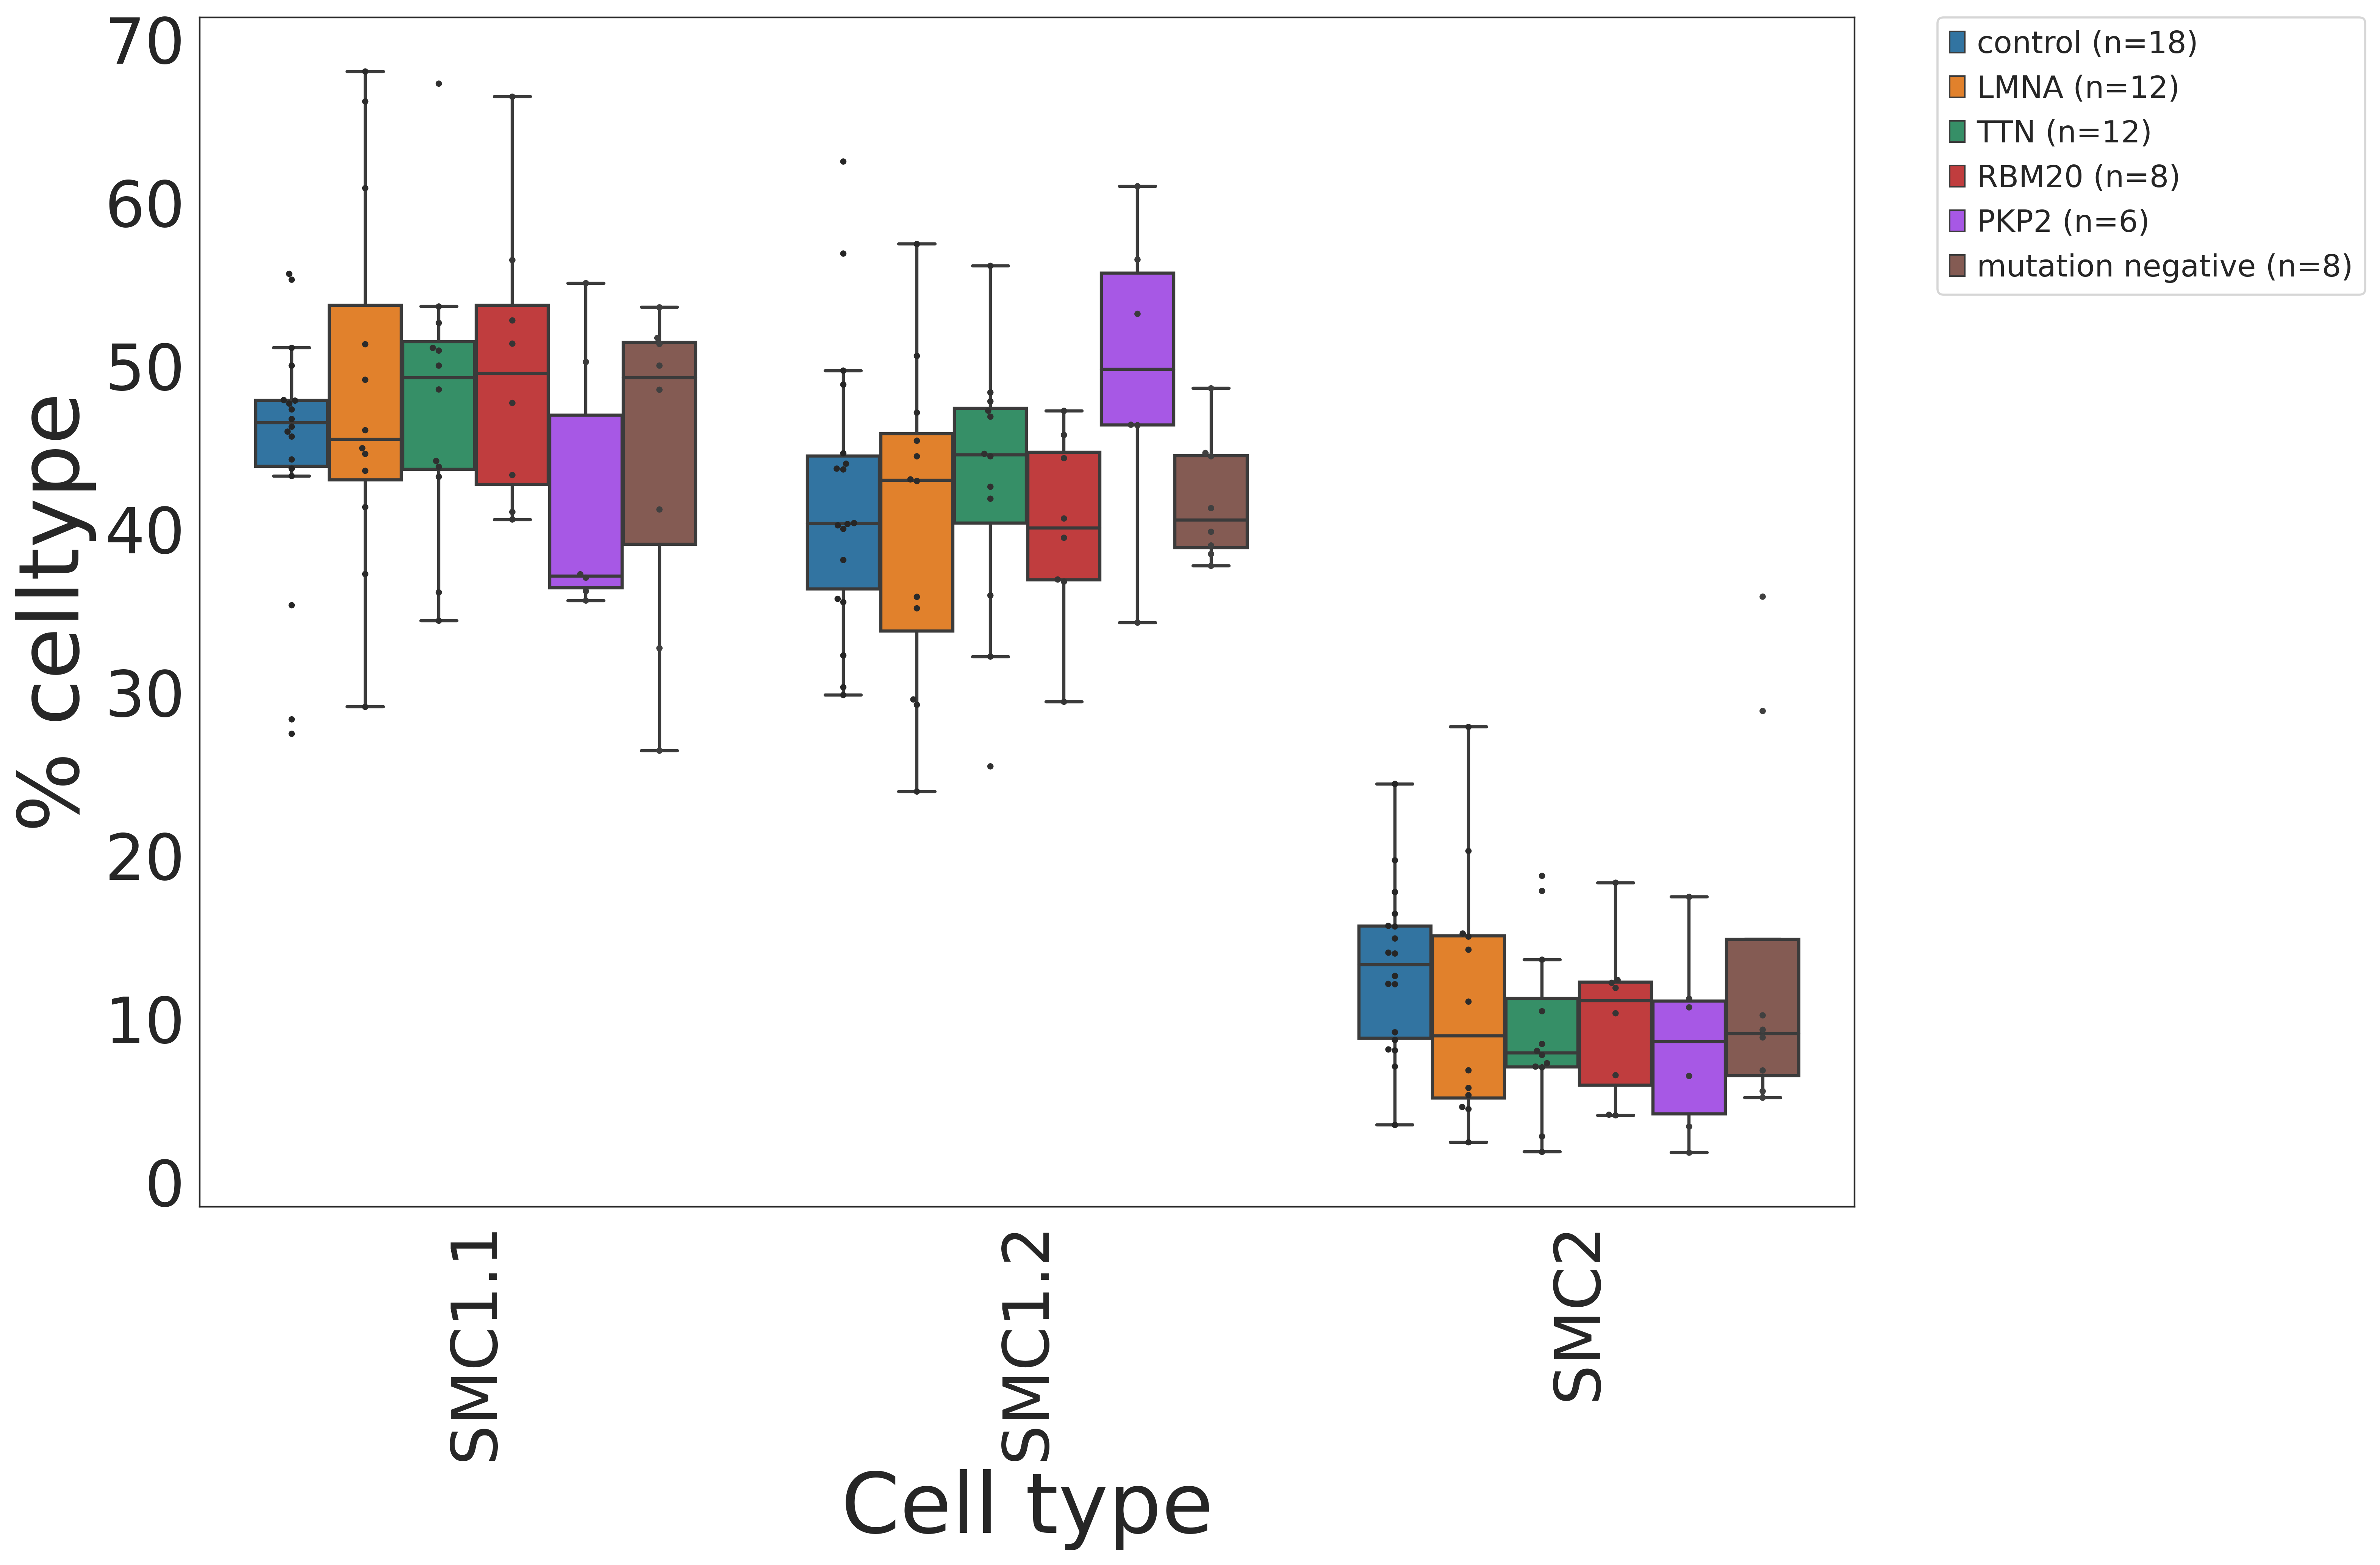

In [40]:
plot_celltype_abundance(mural.obs, 'LVS', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['SMC1.1', 'SMC1.2', 'SMC2'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png='figures/FigS1C_LV_SMC_ab.pdf', ylimit=None)

In [41]:
x=plot_celltype_abundance(mural.obs, 'LVS', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['SMC1.1', 'SMC1.2', 'SMC2'], 
                            plottype="boxplot", 
                            return_table=True)
x.columns=['Patient', 'cell_state', 'abundance_percent', 'Mutation']
#x.to_csv("SMC_CELLSTATE_ABUNDANCE_LV.csv")
x

Patient cell_state  abundance_percent                 Mutation
0   BS_H15     SMC1.1          44.250871           control (n=18)
1   BS_H20     SMC1.1          47.315436           control (n=18)
2   BS_H25     SMC1.1          43.690638           control (n=18)
3   BS_H26     SMC1.1          45.655376           control (n=18)
4   BS_H35     SMC1.1          47.889610           control (n=18)
..     ...        ...                ...                      ...
19     H56       SMC2           9.322034  mutation negative (n=8)
20     H57       SMC2          35.849057  mutation negative (n=8)
21     H58       SMC2          28.846154  mutation negative (n=8)
22     H59       SMC2           8.849558  mutation negative (n=8)
23  IC_H04       SMC2           5.555556  mutation negative (n=8)

[192 rows x 4 columns]

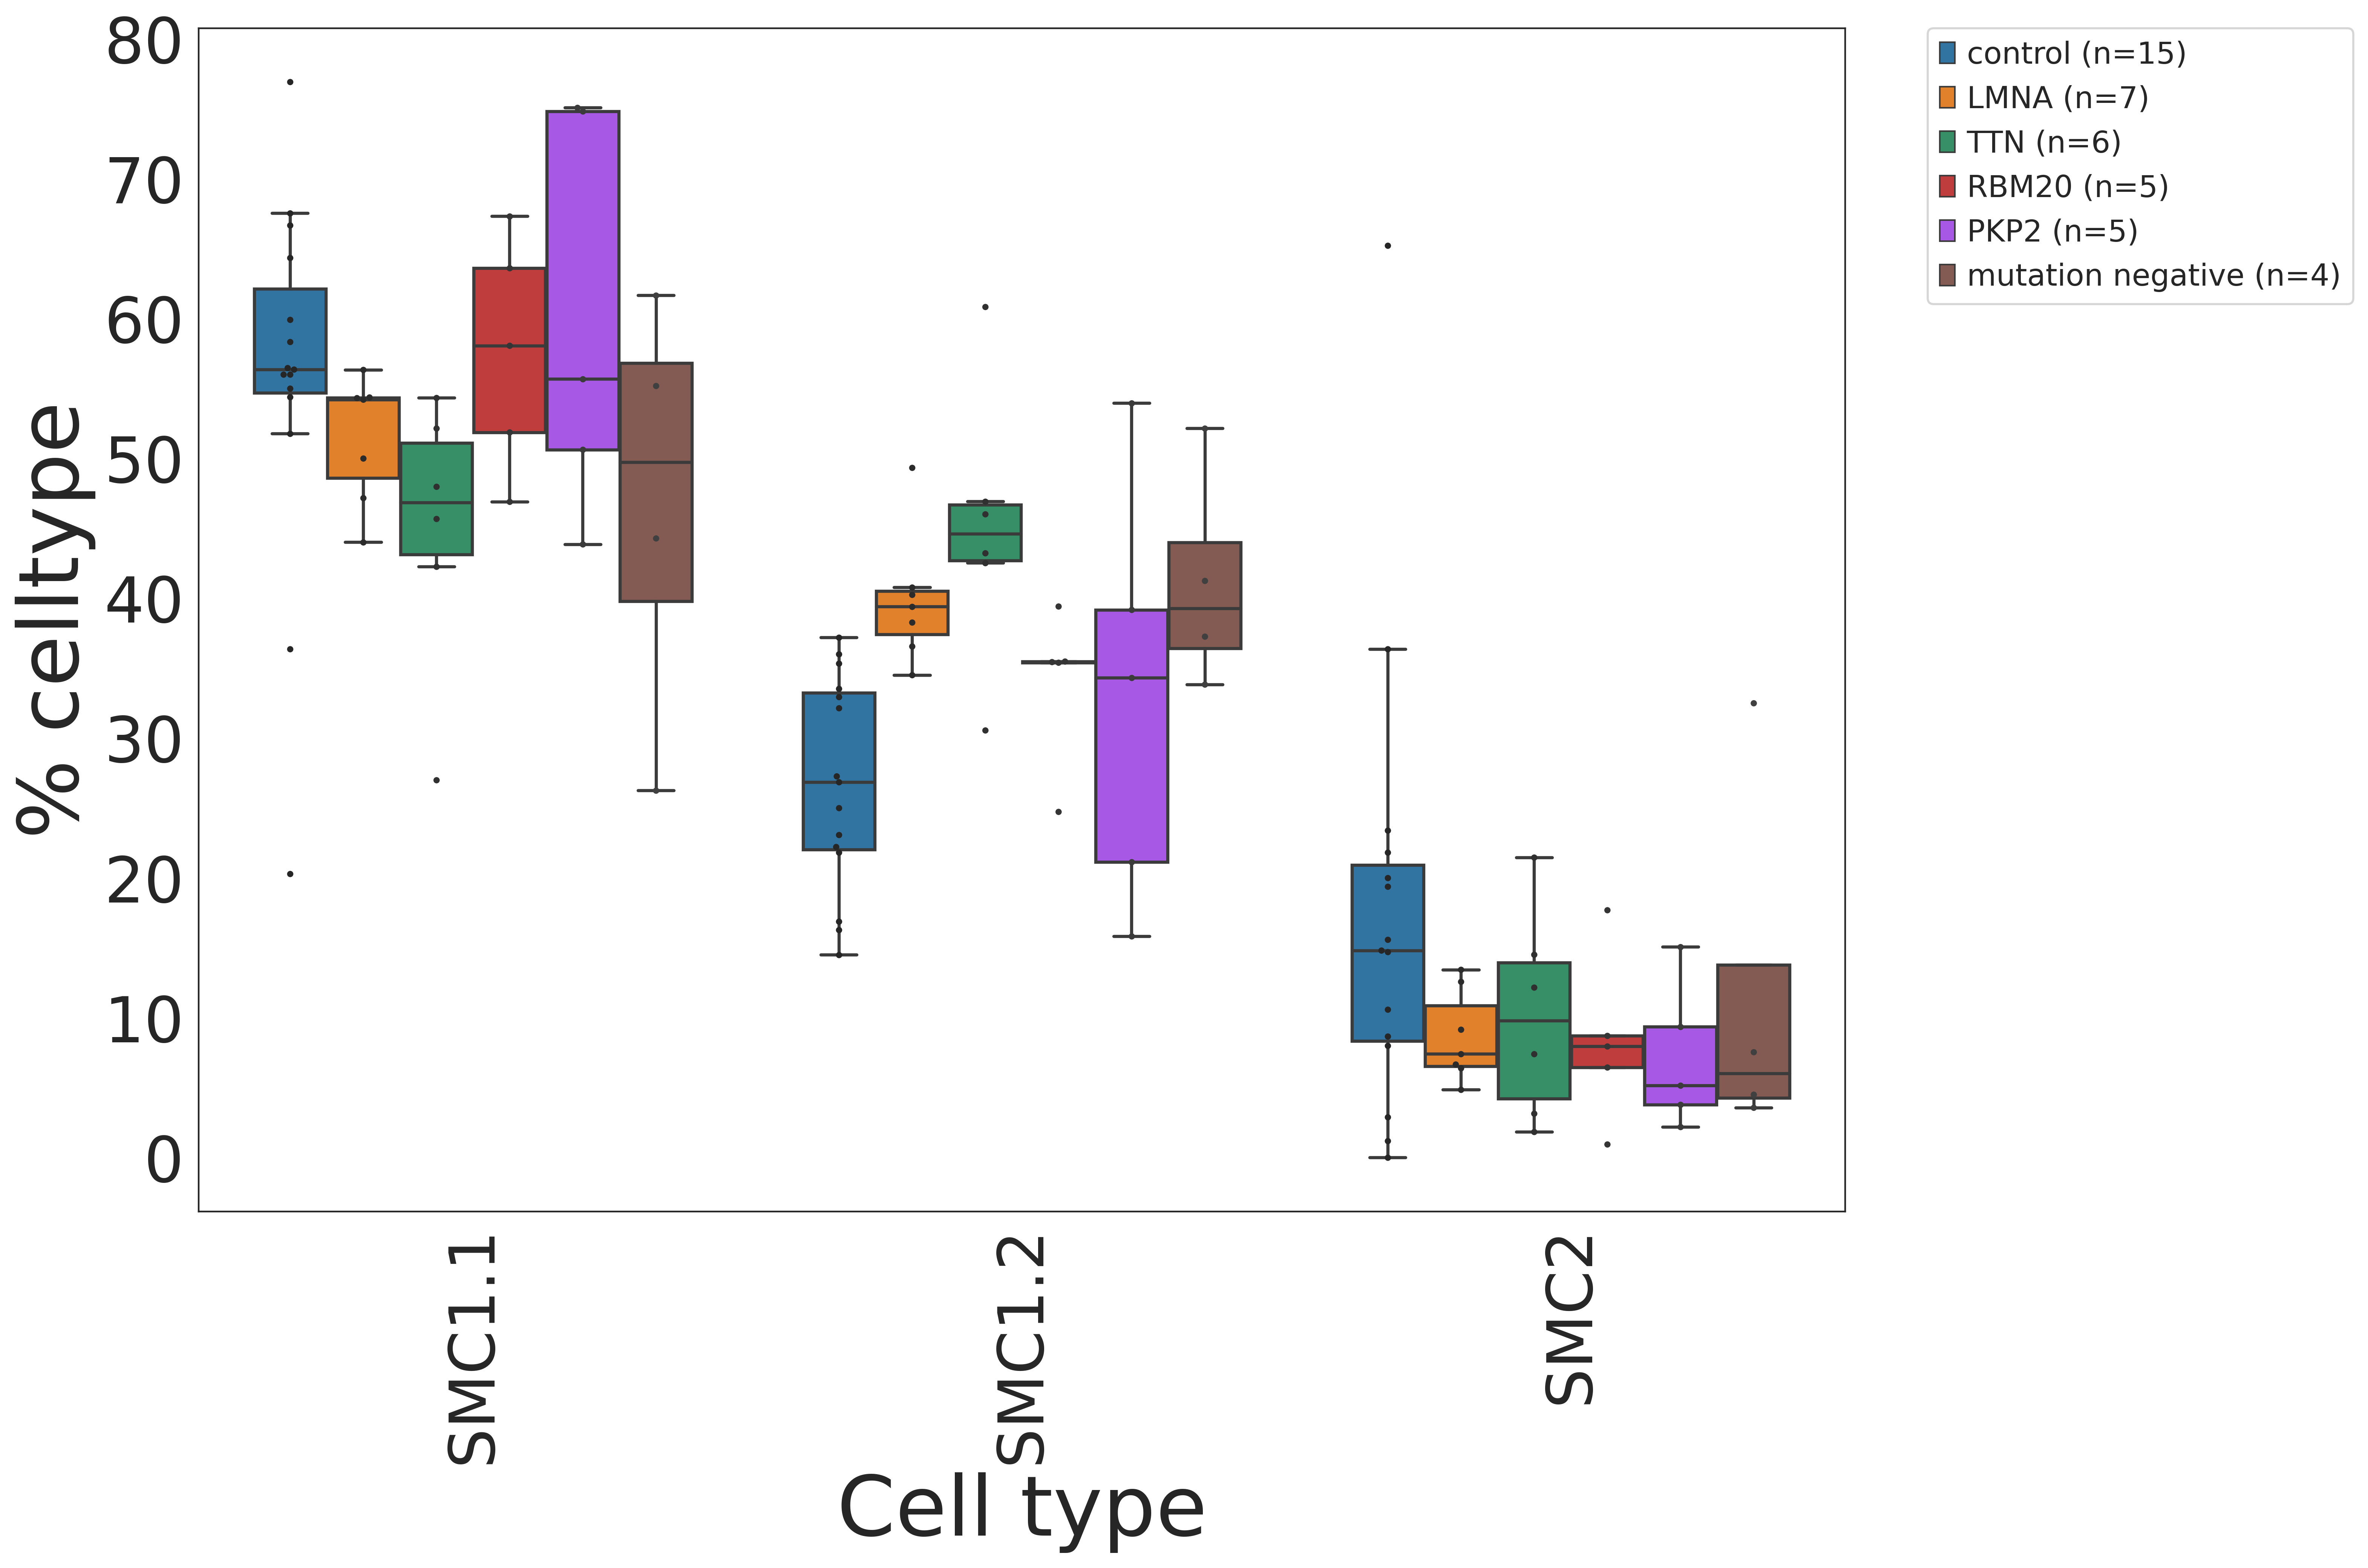

In [42]:
plot_celltype_abundance(mural.obs, 'RV', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['SMC1.1', 'SMC1.2', 'SMC2'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png='figures/FigS1C_RV_SMC_ab.pdf', ylimit=None)

In [43]:
x=plot_celltype_abundance(mural.obs, 'RV', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['SMC1.1', 'SMC1.2', 'SMC2'], 
                            plottype="boxplot", 
                            return_table=True)
x.columns=['Patient', 'cell_state', 'abundance_percent', 'Mutation']
#x.to_csv(path_out + "SMC_CELLSTATE_ABUNDANCE_RV.csv")
x

Patient cell_state  abundance_percent                 Mutation
0   BS_H15     SMC1.1          56.000000           control (n=15)
1   BS_H20     SMC1.1          64.341085           control (n=15)
2   BS_H25     SMC1.1          54.385965           control (n=15)
3   BS_H26     SMC1.1          56.000000           control (n=15)
4   BS_H35     SMC1.1          51.764706           control (n=15)
..     ...        ...                ...                      ...
7   IC_H04     SMC1.2          41.250000  mutation negative (n=4)
8      H01       SMC2           7.547170  mutation negative (n=4)
9      H02       SMC2           4.511278  mutation negative (n=4)
10     H03       SMC2           3.571429  mutation negative (n=4)
11  IC_H04       SMC2          32.500000  mutation negative (n=4)

[126 rows x 4 columns]

PCs + SMCs, not used in the manuscript

/home/jruizor/.local/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruizor/.local/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


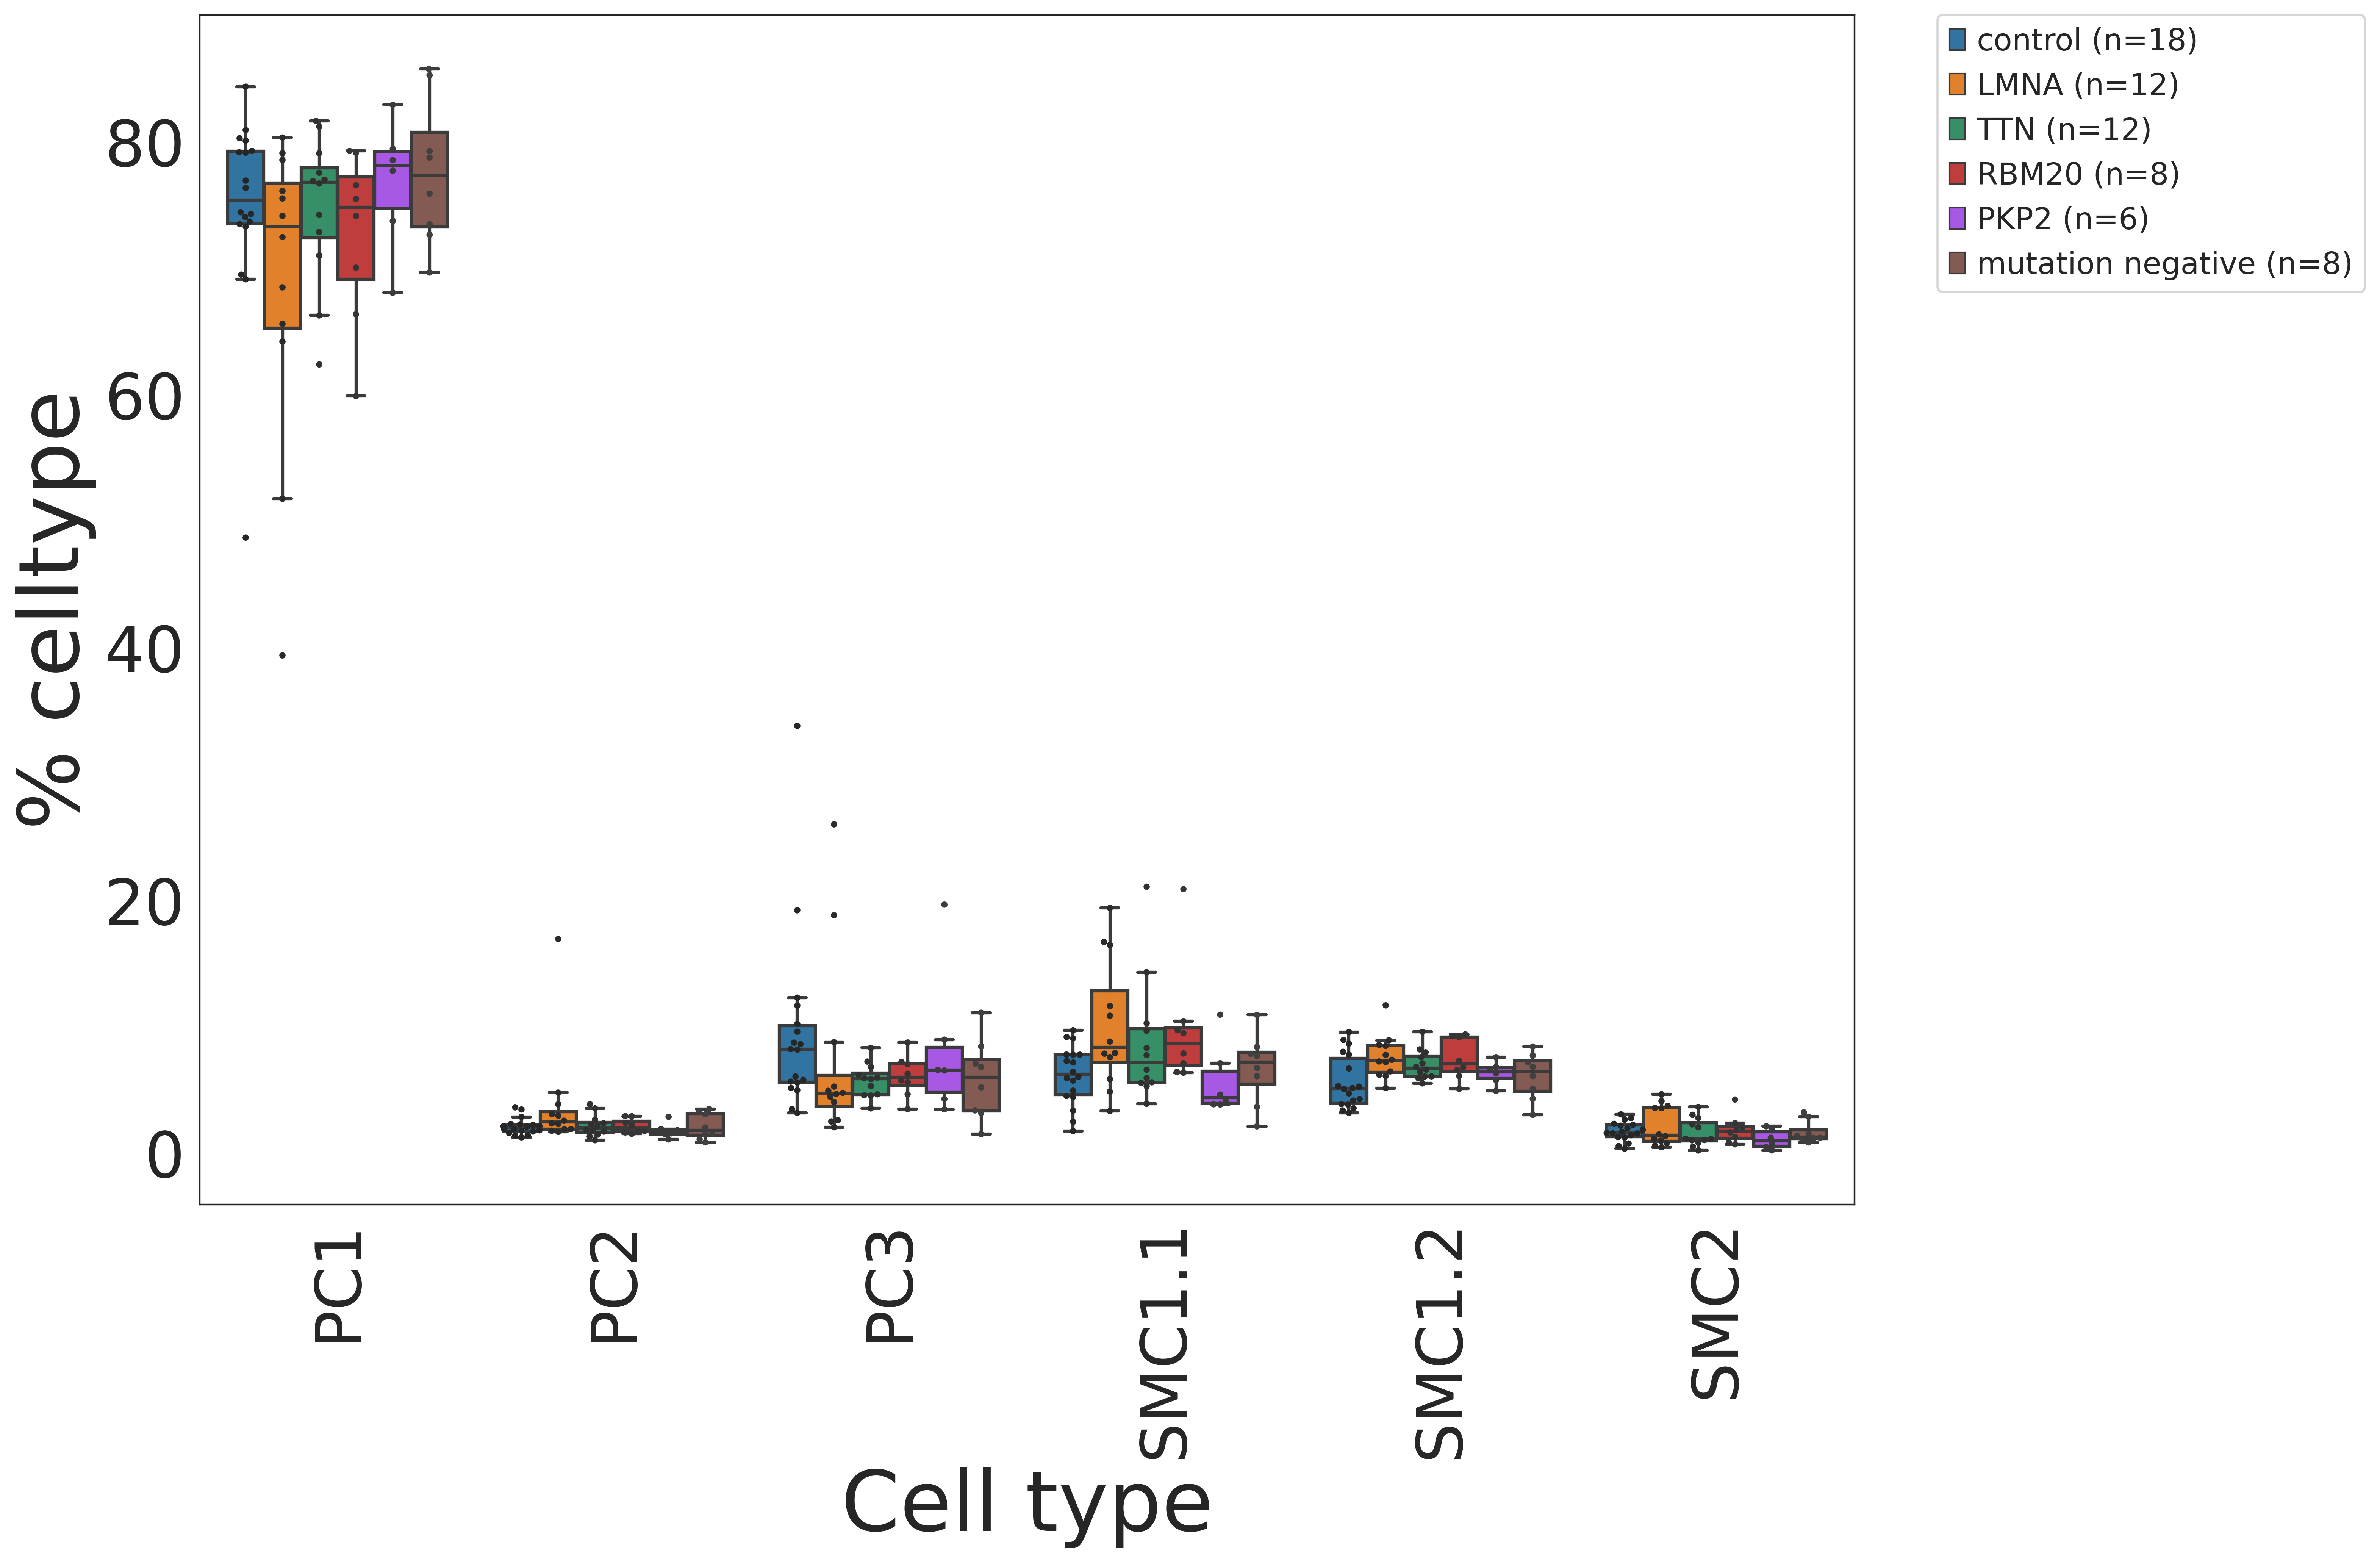

In [44]:
plot_celltype_abundance(mural.obs, 'LVS', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['PC1','PC2','PC3','SMC1.1', 'SMC1.2', 'SMC2'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png=None, ylimit=None)

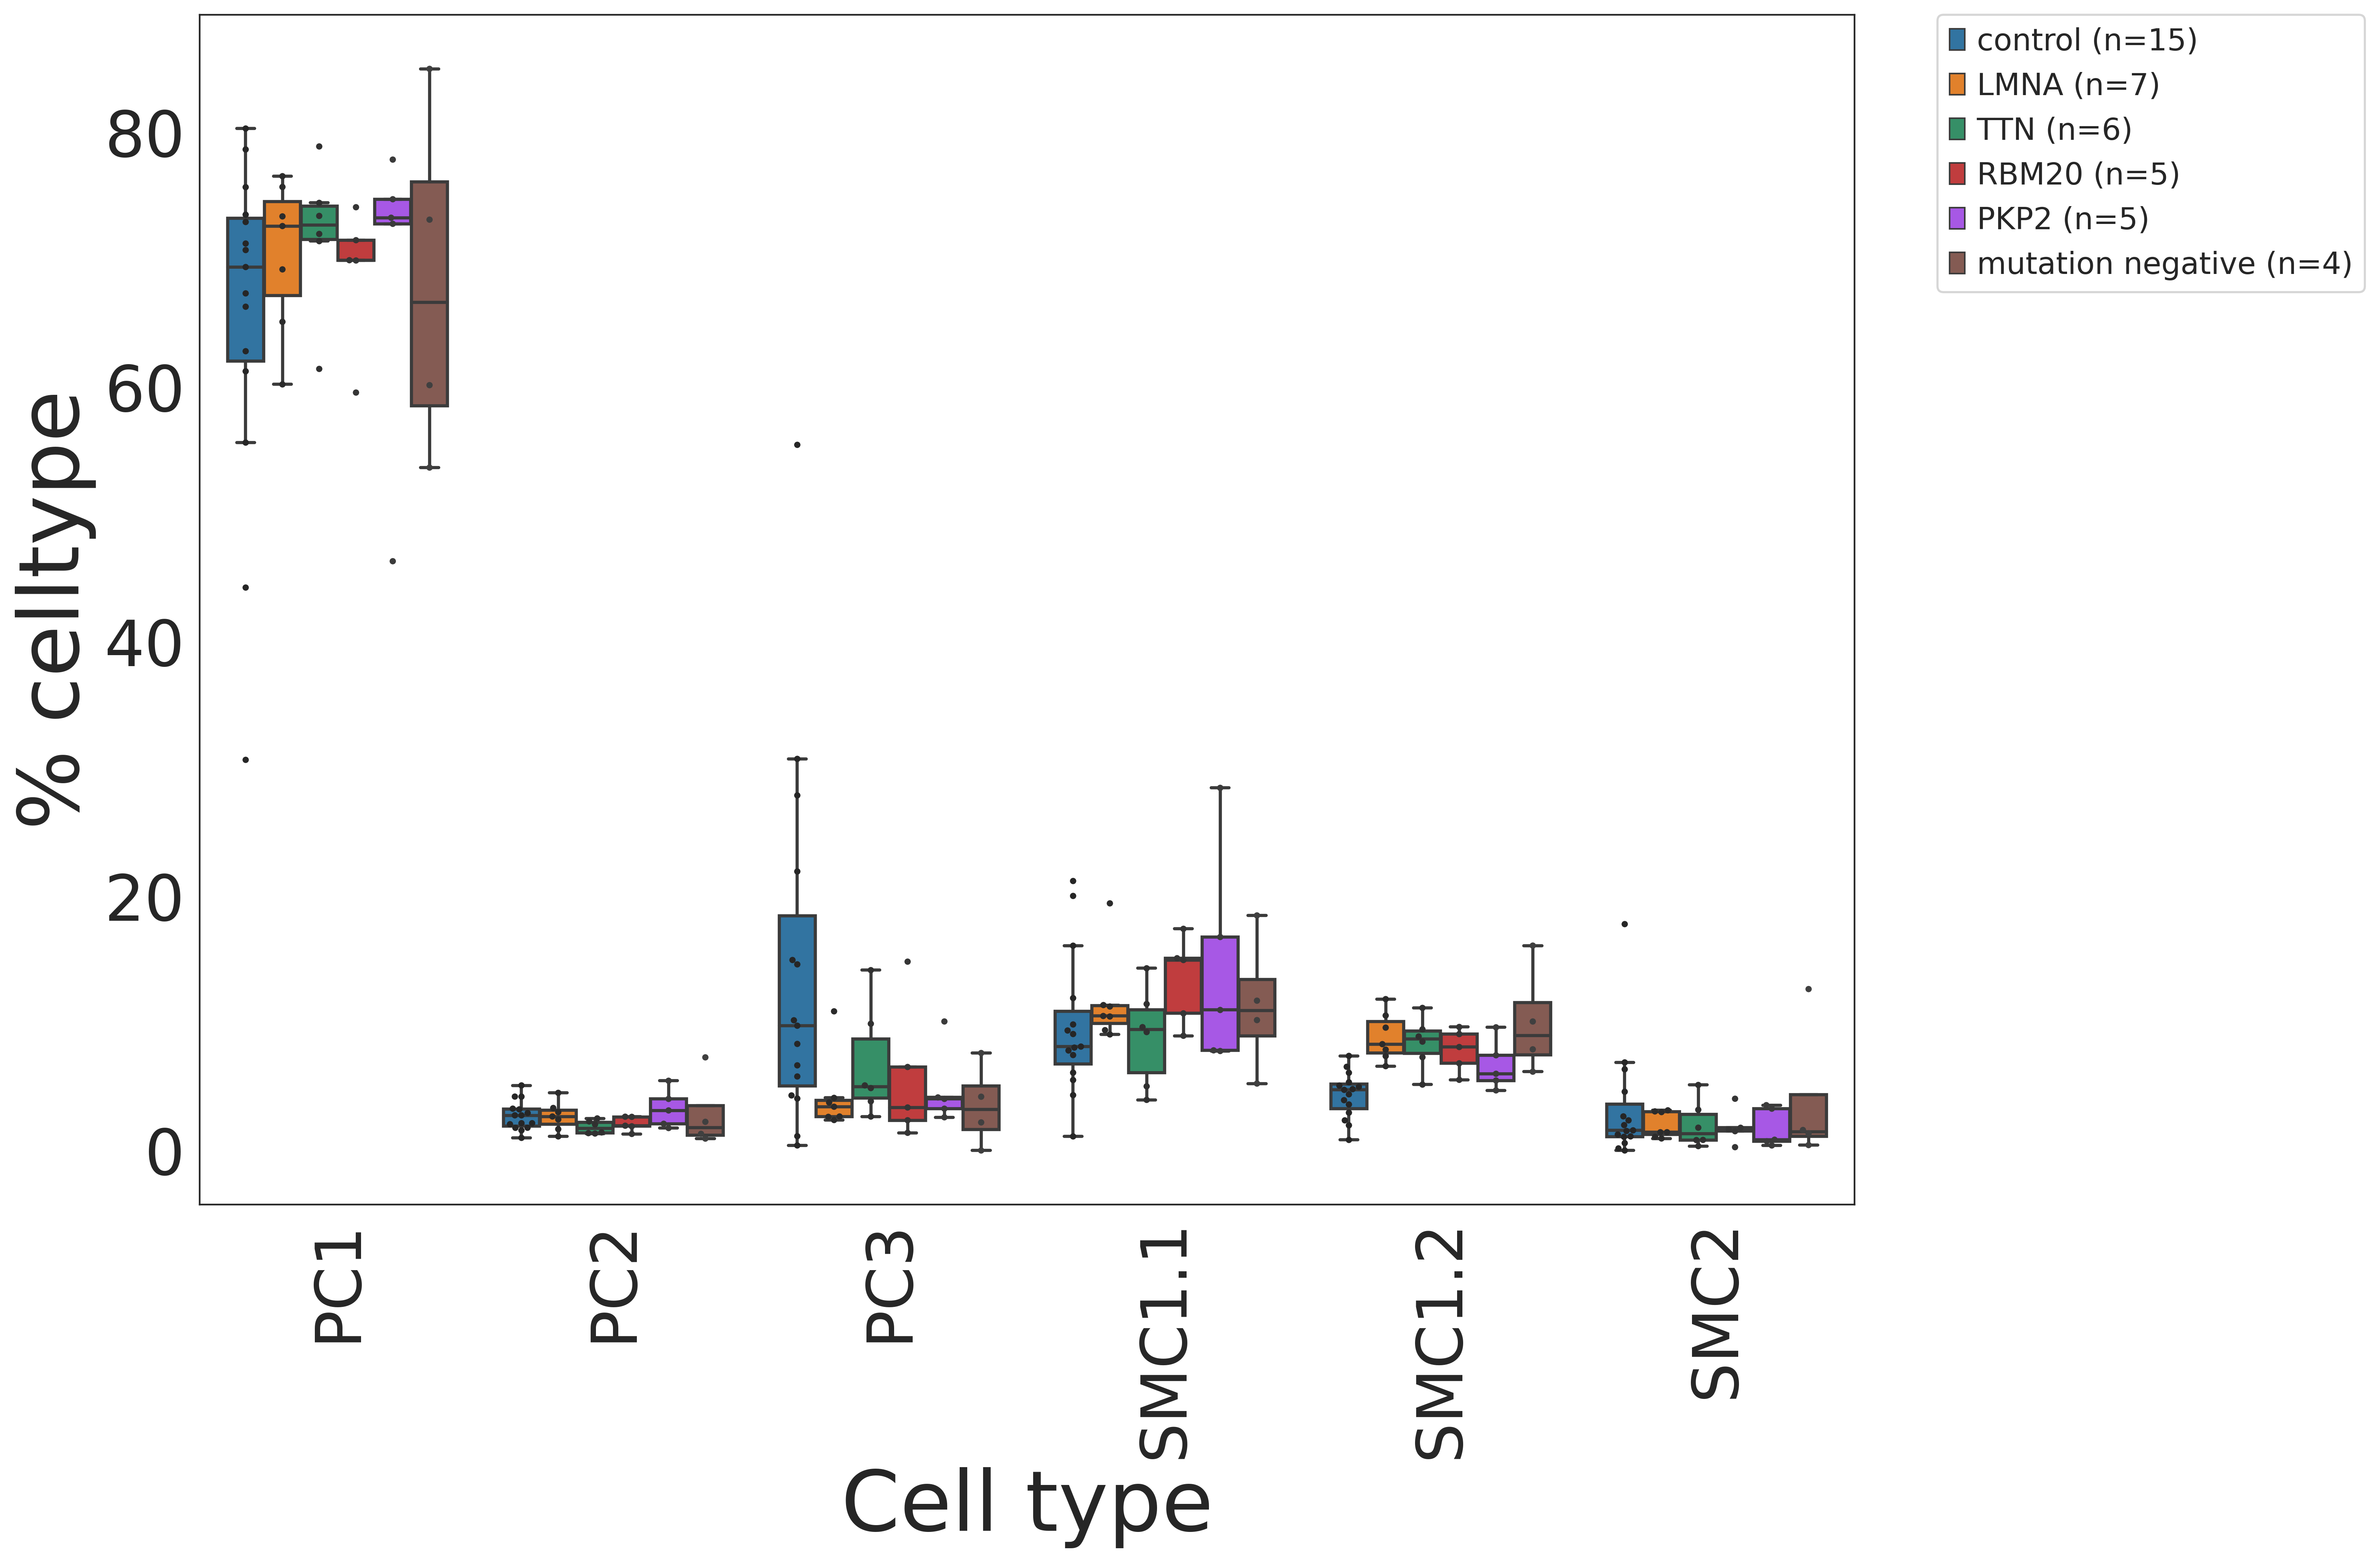

In [45]:
plot_celltype_abundance(mural.obs, 'RV', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'mutation negative'], 
                            celltypes_to_plot=['PC1','PC2','PC3','SMC1.1', 'SMC1.2', 'SMC2'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png=None, ylimit=None)

# Plot interesting gene as pseudobulk

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/co

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/co

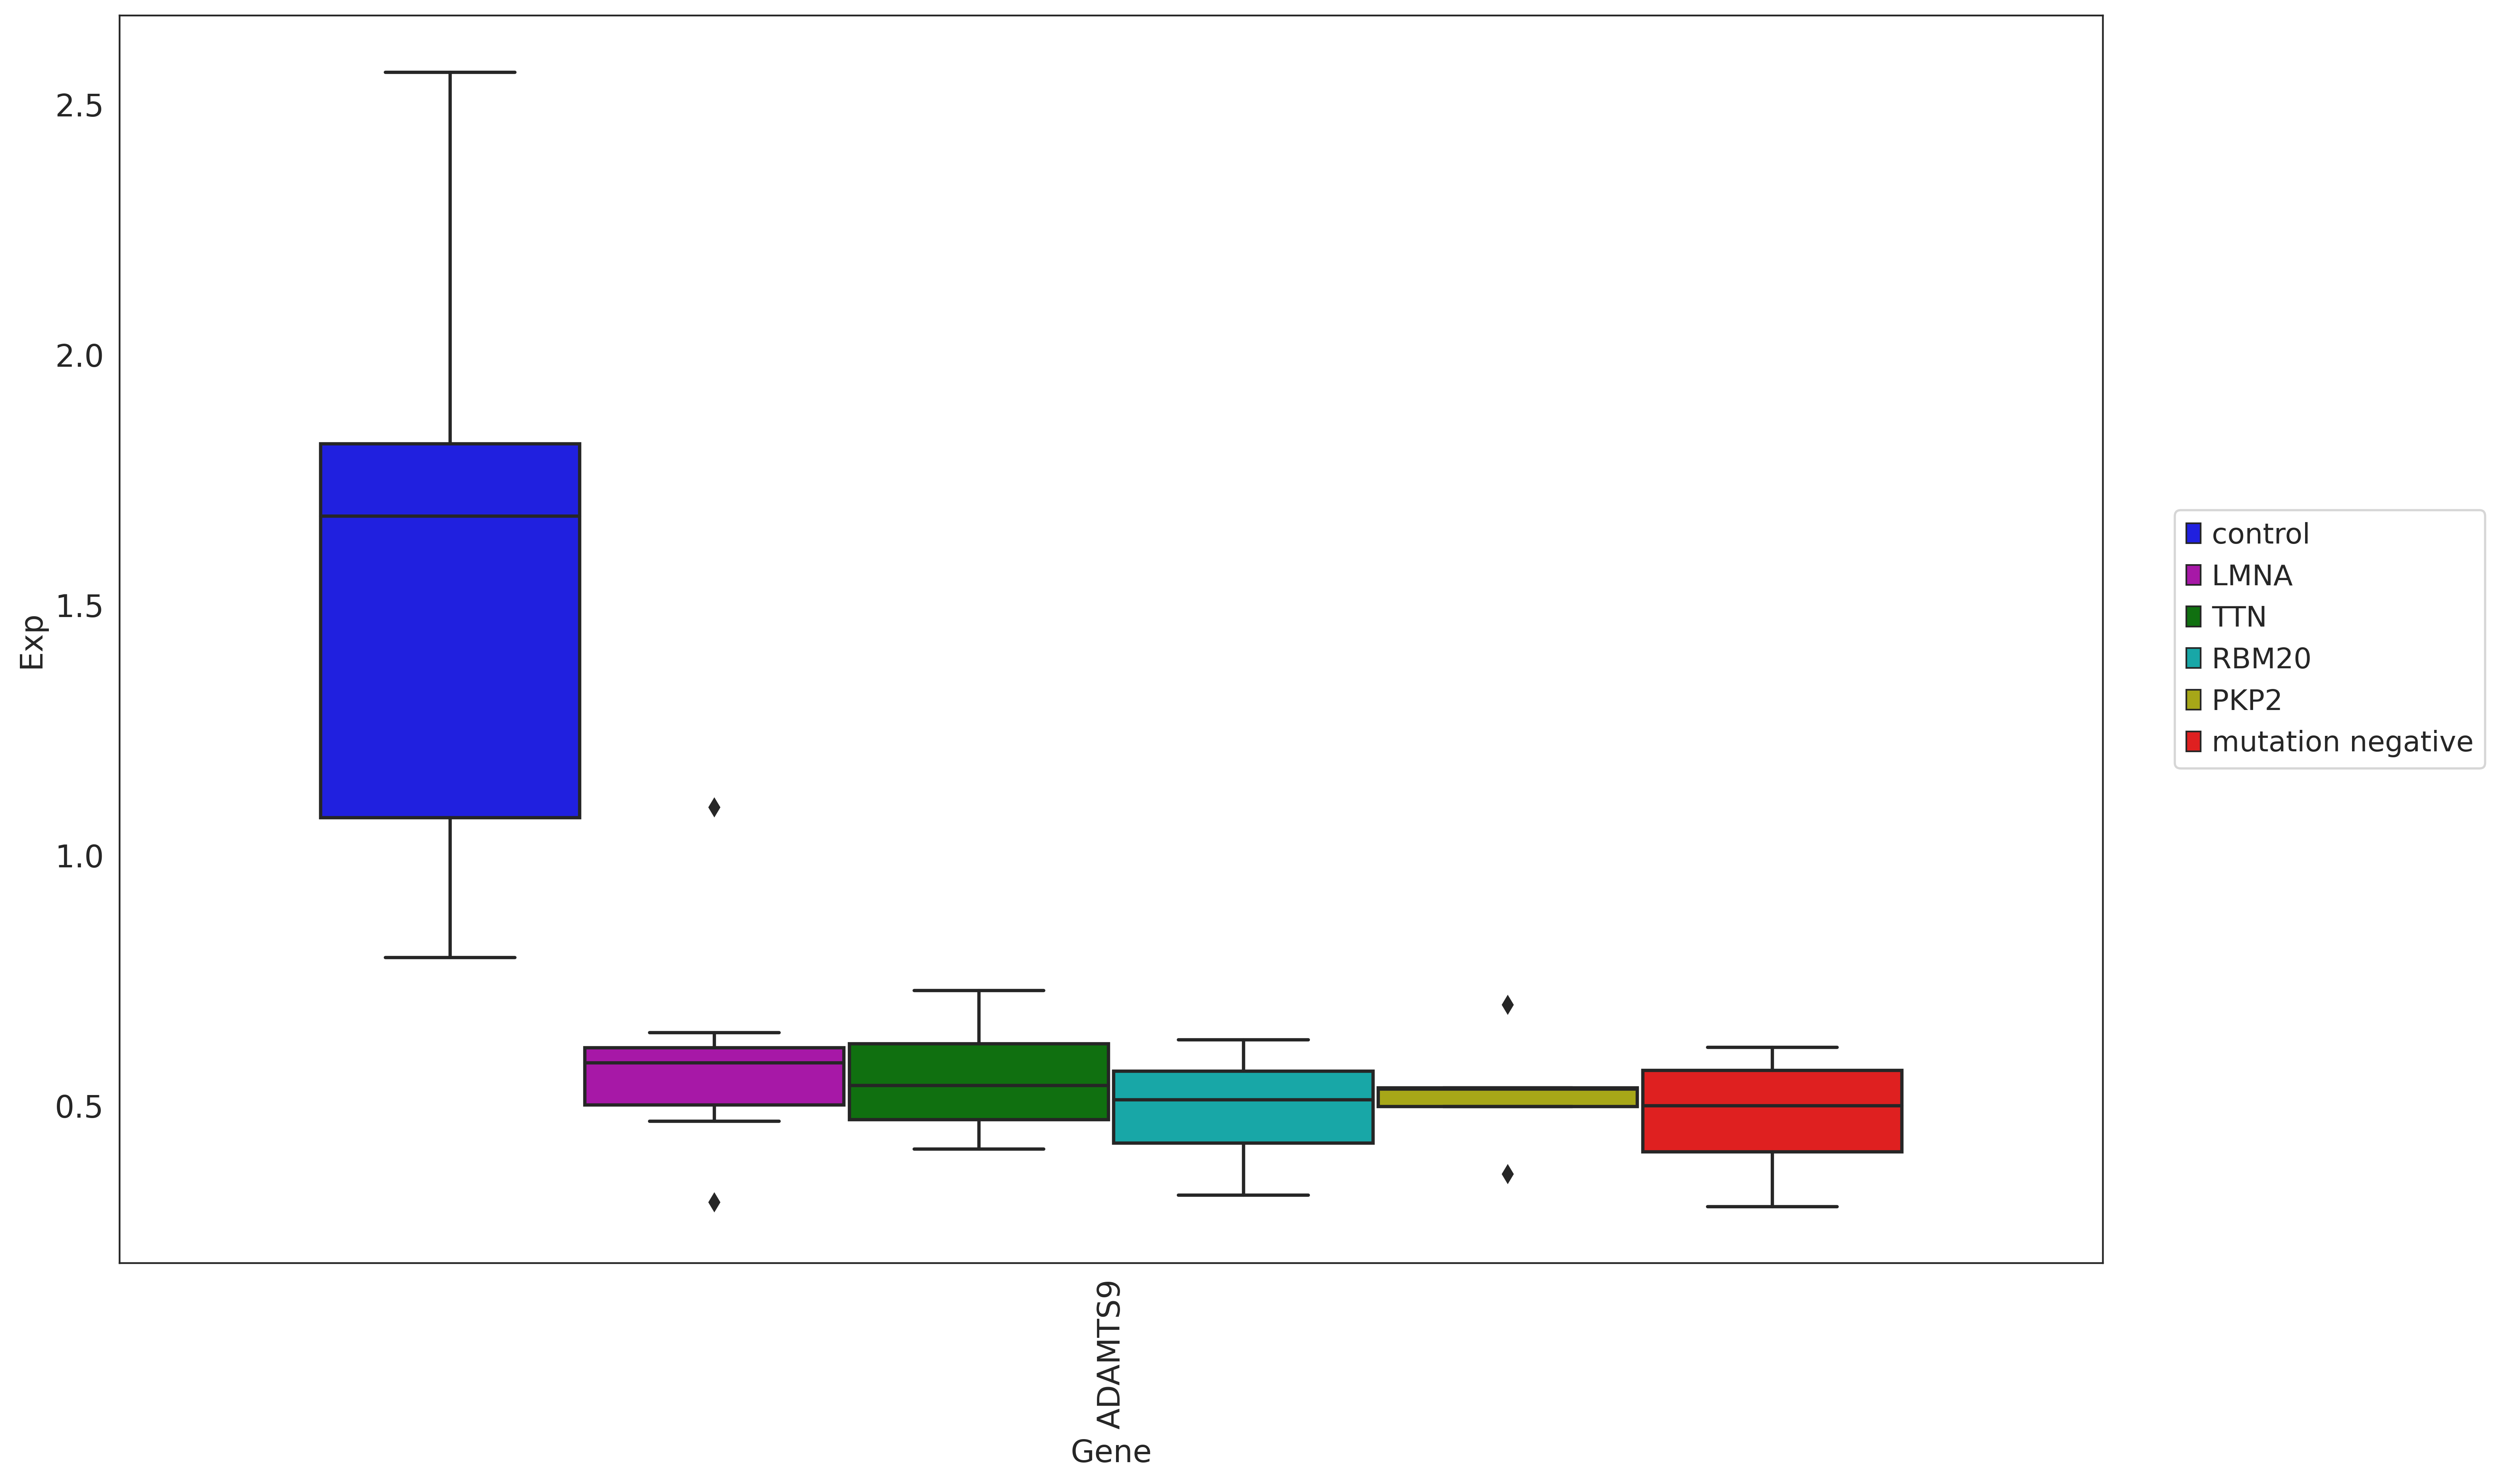

In [47]:
df=average_expression(mural, ['ADAMTS9'], ['PC1','PC2','PC3','SMC1.1','SMC.1.2','SMC2'], Region=['LV','RV'])
%matplotlib inline
plt.figure(figsize=[16,10], dpi=200, facecolor='w', edgecolor='k')

plot_=sns.boxplot(x="Gene", y="Exp",
            hue="Diagnosis", palette=['b', "m", "g", 'c', 'y', 'r'],
            data=df)

plt.setp(plot_.get_xticklabels(), rotation=90)
#plot_.legend(loc=5)
plot_.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)
plt.savefig('figures/FigS1E_adamts9.pdf', transparent=True)

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/co

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/co

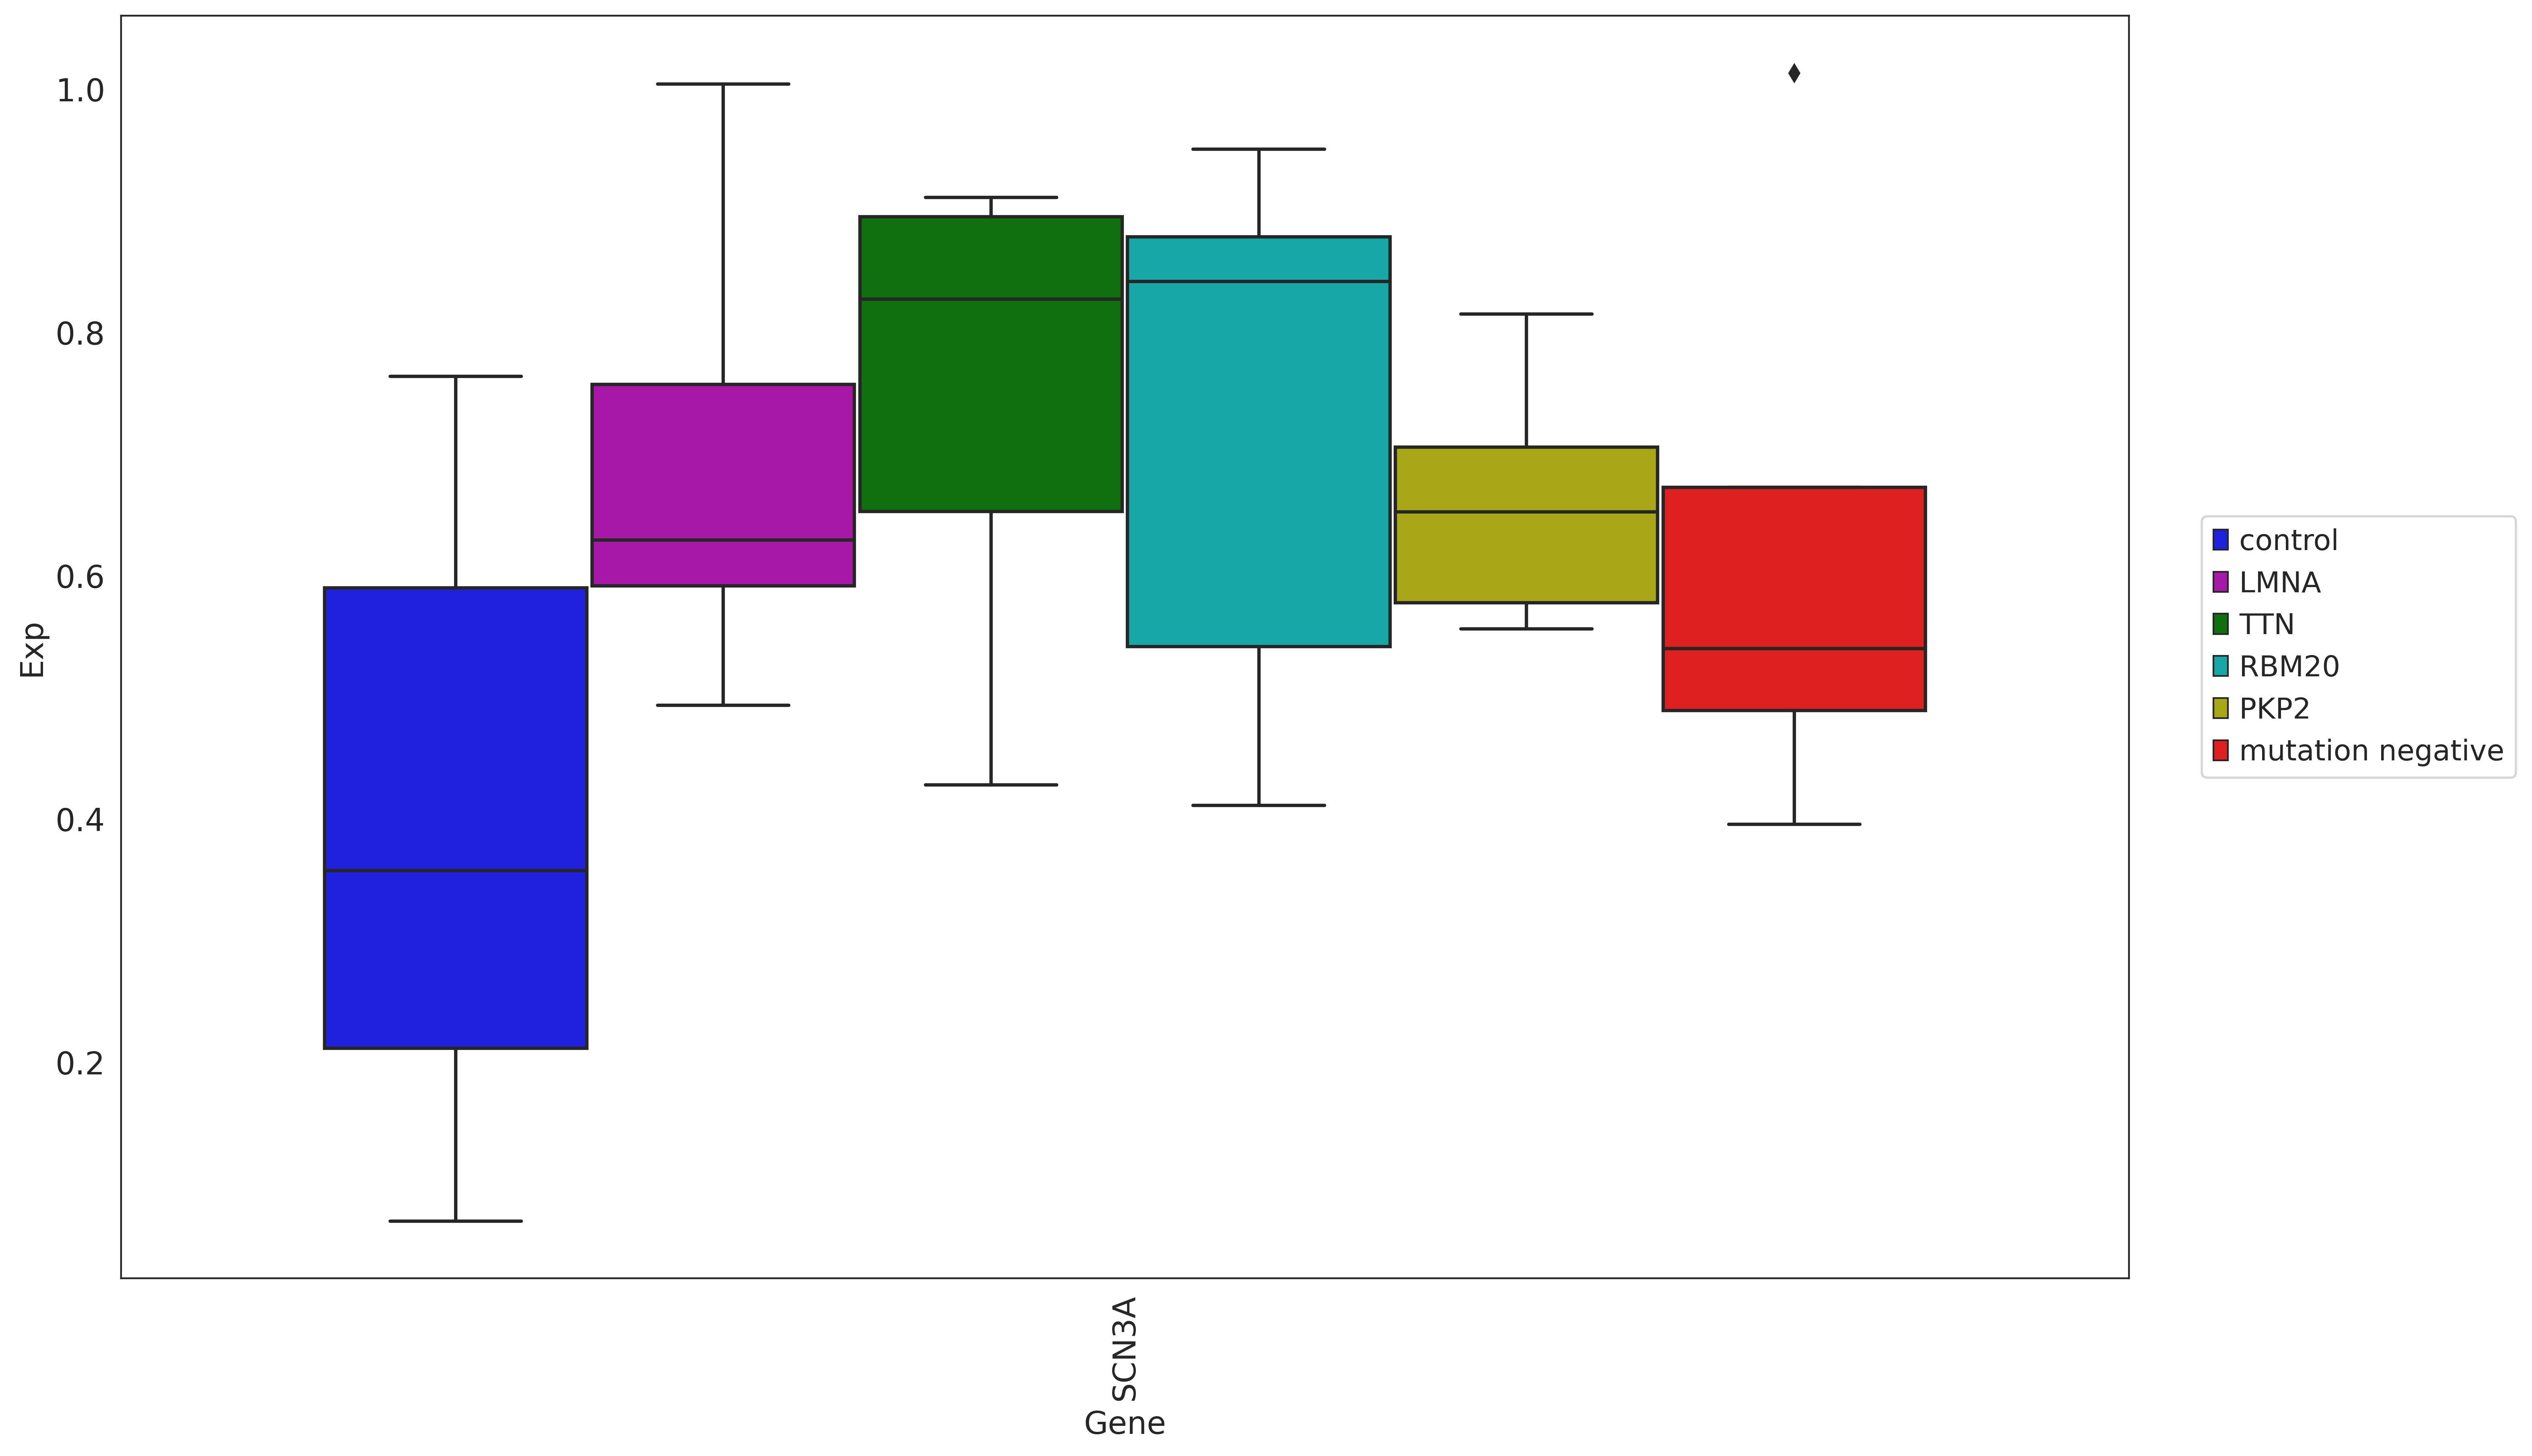

In [48]:
df=average_expression(mural, ['SCN3A'], ['PC1','PC2','PC3','SMC1.1','SMC.1.2','SMC2'], Region=['LV','RV'])
%matplotlib inline
plt.figure(figsize=[16,10], dpi=200, facecolor='w', edgecolor='k')

plot_=sns.boxplot(x="Gene", y="Exp",
            hue="Diagnosis", palette=['b', "m", "g", 'c', 'y', 'r'],
            data=df)

plt.setp(plot_.get_xticklabels(), rotation=90)
#plot_.legend(loc=5)
plot_.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)
plt.savefig('figures/FigS1E_scn3a.pdf', transparent=True)

## Other unused plots

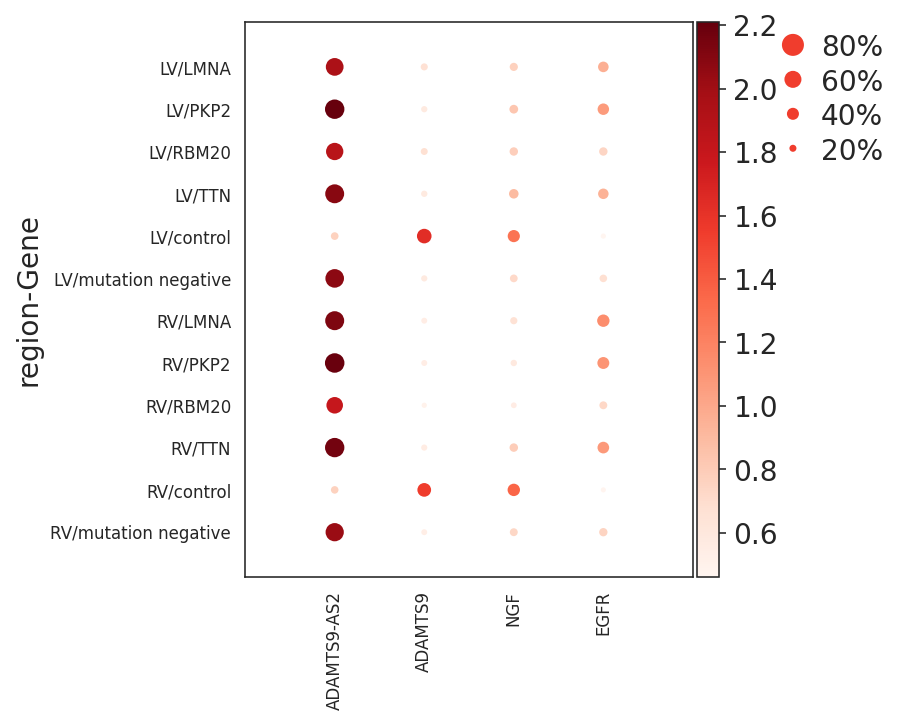

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.05, 0, 0.2, 0.5, 0.25])

In [49]:
sc.pl.dotplot(mural,['ADAMTS9-AS2','ADAMTS9','NGF','EGFR'],groupby="region-Gene", dot_min = 0, use_raw=True, figsize=[5,5])

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


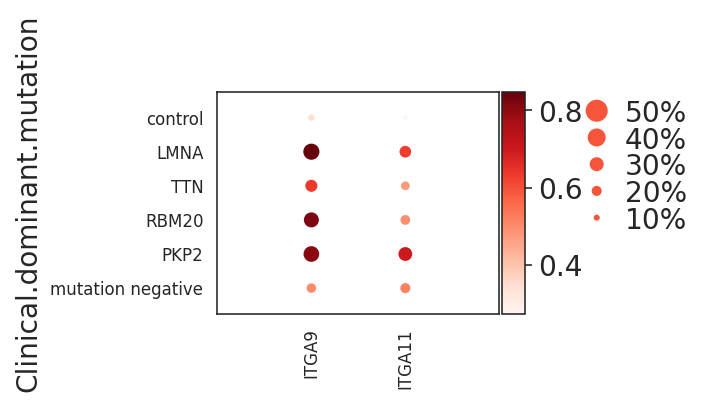

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.55, 0, 0.2, 0.5, 0.25])

In [50]:
sc.pl.dotplot(mural[mural.obs.cell_states.isin(['SMC2'])],['ITGA9','ITGA11'],groupby="Clinical.dominant.mutation", dot_min = 0, use_raw=True, figsize=[3.5,2])

/home/jruizor/.local/lib/python3.8/site-packages/pandas-1.2.0rc0-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


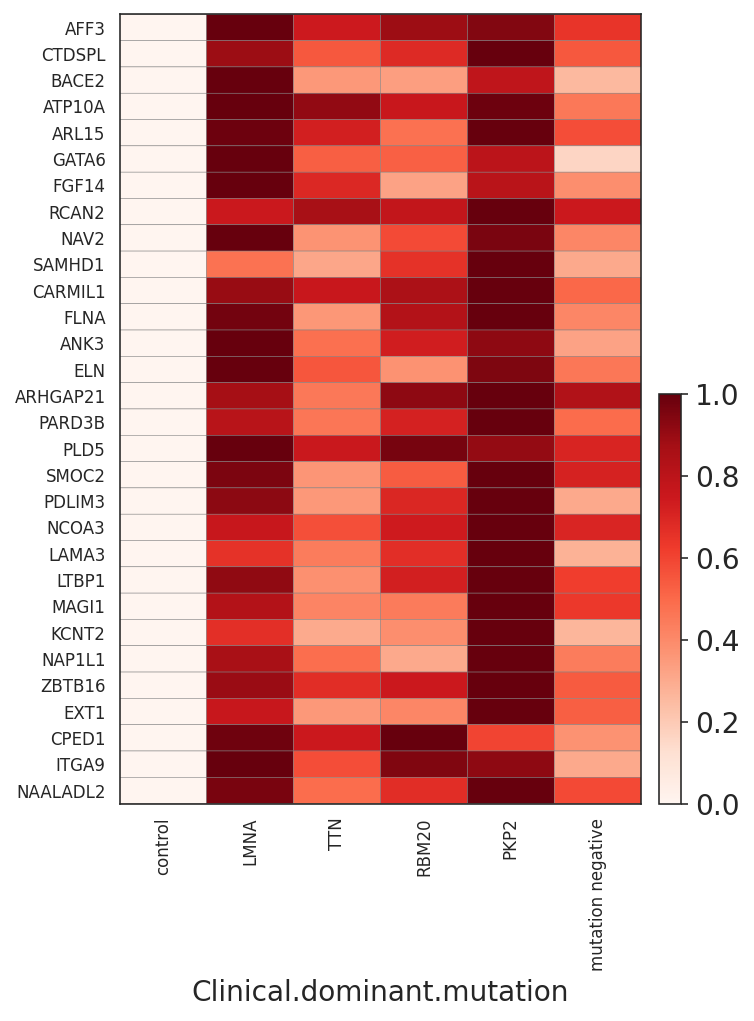

GridSpec(2, 3, height_ratios=[0, 7], width_ratios=[4.8, 0, 0.2])

In [51]:
df_smc2_lmna = ["AFF3", "CTDSPL", "BACE2", "ATP10A", "ARL15", "GATA6", "FGF14", "RCAN2", "NAV2", "SAMHD1", "CARMIL1", "FLNA", "ANK3", "ELN", "ARHGAP21", "PARD3B", "PLD5", "SMOC2", "PDLIM3", "NCOA3", "LAMA3", "LTBP1", "MAGI1", "KCNT2", "NAP1L1", "ZBTB16", "EXT1", "CPED1", "ITGA9", "NAALADL2"]
sc.pl.matrixplot(mural[mural.obs.cell_states.isin(['SMC2'])],df_smc2_lmna,groupby="Clinical.dominant.mutation", swap_axes=True, cmap='Reds', standard_scale='var', figsize=[5,7])